In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Original"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.ppm'))  # assuming the images are stored as 'ppm'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tClass: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.ppm'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Class:     fraterculus	Number of images: 100
Label: 1	Class:         obliqua	Number of images: 101
Label: 2	Class:       sororcula	Number of images: 100
Processing images ...
Images processed: 301


In [4]:
X.shape

(301, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
list_paths

['/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F035-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F025-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F084-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F062-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F021-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F042-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F098-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F115-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F048-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F010-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F022-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F006-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F055-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F110-G-1,5x.ppm'

In [7]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds
skfind = []
test_fold = np.zeros((num_samples,), dtype=int)-1
for i in range(kfold):
    train_ind = []
    print('Datasets/Folds/Fold-Train%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Train%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            print('[%d] %s' %(list_paths.index([s for s in list_paths if fname in s][0]),fname))
            train_ind.append(list_paths.index([s for s in list_paths if fname in s][0]))
    print('[%d] Train fold size: %d' %(i,len(train_ind)))
    print(train_ind)
    test_ind = []
    print('Datasets/Folds/Fold-Test%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Test%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            sample_idx = list_paths.index([s for s in list_paths if fname in s][0])
            print('[%d] %s' %(sample_idx,fname))
            test_ind.append(sample_idx)
            test_fold[sample_idx] = i
    print('[%d] Test fold size: %d' %(i,len(test_ind)))
    print(test_ind)
    #skfind.append((np.array(train_ind),np.array(test_ind)))
    skfind.append((train_ind,test_ind))
print('SKFIND')
print(skfind)
print('TEST_FOLD')
print(test_fold)

Datasets/Folds/Fold-Train1.txt
[11] F006-1,5x.ppm
[66] F009-1,5x.ppm
[68] F016,1,5x.ppm
[10] F022-1,5x.ppm
[33] F027-1,5x.ppm
[30] F033-1,5x.ppm
[39] F037-1,5x.ppm
[67] F041-1,5x.ppm
[77] F050-1,5x.ppm
[96] F054-1,5x.ppm
[41] F063-1,5x.ppm
[23] F072-G-1,5x.ppm
[83] F077-G-1,5x.ppm
[18] F090-G-1,5x.ppm
[44] F093-G-1,5x.ppm
[15] F094-G-1,5x.ppm
[63] F095-G-1,5x.ppm
[99] F106-G-1,5x.ppm
[53] F108-G-1,5x.ppm
[47] F132-N-1,5x.ppm
[254] S093-1,5x.ppm
[216] S094-1,5x.ppm
[288] S095-1,5x.ppm
[213] S096-1,5x.ppm
[279] S098-1,5x.ppm
[207] S099-1,5x.ppm
[209] S100-1,5x.ppm
[259] S101-1,5x.ppm
[300] s102-1,5x.ppm
[268] S103-1,5x.ppm
[278] S104-1,5x.ppm
[251] S105-1,5x.ppm
[267] S106-1,5x.ppm
[281] S108-1,5x.ppm
[244] S109-1,5x.ppm
[229] S111-1,5x.ppm
[247] S112-1,5x.ppm
[208] S116-1,5x.ppm
[261] S118-1,5x.ppm
[234] S123-1,5x.ppm
[131] B001-1,5x.ppm
[193] B003,1,5x.ppm
[140] B009-1,5x.ppm
[167] B012-1,5X.ppm
[195] B018-1,5x.ppm
[162] B019-1,5x.ppm
[158] B024-1,5x.ppm
[110] B032-1,5x.ppm
[137] B038-

[179] B004-1,5x.ppm
[116] B050-1,5x.ppm
[200] B088-G01,5x.ppm
[128] B026-15x.ppm
[185] B052-1,5x.ppm
[159] B008-1,5x.ppm
[184] B010-1,5x.ppm
[111] B065-1,5x.ppm
[170] B067-G-1,5x.ppm
[118] B087-G-1,5x.ppm
[171] B040-1,5x.ppm
[107] B079-G-1,5x.ppm
[192] B044-1,5x.ppm
[114] B005-1,5x.ppm
[161] B063-G-1,5x.ppm
[181] B046-1,5x.ppm
[2] Train fold size: 241
[1, 35, 95, 91, 62, 2, 76, 81, 43, 71, 17, 55, 88, 42, 19, 87, 20, 97, 94, 8, 262, 245, 257, 250, 291, 285, 290, 274, 226, 205, 232, 228, 203, 240, 242, 282, 211, 271, 294, 224, 152, 176, 160, 155, 189, 180, 146, 126, 115, 182, 166, 141, 139, 130, 145, 138, 112, 135, 173, 101, 11, 66, 68, 10, 33, 30, 39, 67, 77, 96, 41, 23, 83, 18, 44, 15, 63, 99, 53, 47, 254, 216, 288, 213, 279, 207, 209, 259, 300, 268, 278, 251, 267, 281, 244, 229, 247, 208, 261, 234, 131, 193, 140, 167, 195, 162, 158, 110, 137, 134, 129, 194, 153, 150, 174, 100, 127, 106, 149, 142, 175, 69, 85, 46, 12, 84, 3, 22, 25, 89, 34, 49, 0, 92, 45, 56, 29, 16, 36, 74, 93, 225, 

In [8]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [9]:
print("Extracting features from ResNet50 layers ...")
resnet50features = base_model.predict(X)

Extracting features from ResNet50 layers ...


In [10]:
print(resnet50features)

[[ 0.38027704  0.          0.20684466 ...,  1.12184477  0.89628559
   0.49559101]
 [ 0.42370874  0.0989799   0.0193436  ...,  0.74370098  0.51598448
   0.10375948]
 [ 0.26371157  0.10568655  0.74503374 ...,  0.64799303  0.80613029
   0.42094493]
 ..., 
 [ 0.72277623  0.          0.         ...,  0.96262097  0.46300632
   0.04655574]
 [ 0.76662195  0.08702008  0.0531584  ...,  1.37098396  0.24310508
   0.23017983]
 [ 0.43618611  0.00297298  0.17552026 ...,  1.50332224  0.90540612
   0.29464975]]


In [11]:
resnet50features.shape

(301, 2048)

In [12]:
# Adding a custom top layer to the model
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [13]:
# Creating the top model for pre-training
bottleneck_features = Input(shape=resnet50features.shape[1:], name='bottleneck_features')
predictions = Dense(num_classes, activation='softmax', name='predictions')(bottleneck_features)
top_model = Model(inputs=bottleneck_features, outputs=predictions)
top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_features (InputLa (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 3)                 6147      
Total params: 6,147
Trainable params: 6,147
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=200
history = []
tophistory = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='moscas-folds-resnet50-pretrained-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()
init_top_weights = top_model.get_weights()

In [15]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    resnet50features_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    resnet50features_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
  
    print("[%d] Pre-training the top model ..." %(i))

    top_model.set_weights(init_top_weights)

    y_prob = top_model.predict(resnet50features_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    start = time.time()
    h = top_model.fit(resnet50features_train, Y_train, validation_data=(resnet50features_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    tophistory.append(h)
    
    pretrained_top_weights = top_model.get_weights()
          
    y_prob = top_model.predict(resnet50features_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Pre-trained acurracy (top_model): %.4f" %(i,accuracy_score(y_test,y_pred)))
   
    print("[%d] Fine-tuning the model ..." %(i))

    model.set_weights(init_weights)
    model.layers[-1].set_weights(init_top_weights)
    
    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Initial acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))
    
    model.layers[-1].set_weights(pretrained_top_weights)

    #y_prob = model.predict(X_test, verbose=0)  # Testing
    #y_pred = np.argmax(y_prob, axis=1)
    #print("[%d] Pre-trained acurracy (model): %.4f" %(i,accuracy_score(y_test,y_pred)))    
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
        
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Pre-training the top model ...
[0] Initial acurracy (top_model): 0.3000
Train on 241 samples, validate on 60 samples
Epoch 1/200
241/241 [==============================] - 0s - loss: 1.1766 - acc: 0.3610 - val_loss: 0.9509 - val_acc: 0.6333
Epoch 2/200
241/241 [==============================] - 0s - loss: 1.0015 - acc: 0.4896 - val_loss: 0.8415 - val_acc: 0.6167
Epoch 3/200
241/241 [==============================] - 0s - loss: 0.8908 - acc: 0.6141 - val_loss: 0.7806 - val_acc: 0.6500
Epoch 4/200
241/241 [==============================] - 0s - loss: 0.7766 - acc: 0.6888 - val_loss: 0.6726 - val_acc: 0.7667
Epoch 5/200
241/241 [==============================] - 0s - loss: 0.6872 - acc: 0.7469 - val_loss: 0.6007 - val_acc: 0.8167
Epoch 6/200
241/241 [==============================] - 0s - loss: 0.6274 - acc: 0.8091 - val_loss: 0.5718 - val_acc: 0.8167
Epoch 7/200
241/241 [==============================] - 0s - loss: 0.5484 - acc: 0.8506 - val_loss: 0.5152 - val_acc: 0.8333
Epoch 8/200

241/241 [==============================] - 0s - loss: 0.0720 - acc: 1.0000 - val_loss: 0.3058 - val_acc: 0.8833
Epoch 66/200
241/241 [==============================] - 0s - loss: 0.0708 - acc: 1.0000 - val_loss: 0.3063 - val_acc: 0.8833
Epoch 67/200
241/241 [==============================] - 0s - loss: 0.0695 - acc: 1.0000 - val_loss: 0.2998 - val_acc: 0.8833
Epoch 68/200
241/241 [==============================] - 0s - loss: 0.0680 - acc: 1.0000 - val_loss: 0.3033 - val_acc: 0.8833
Epoch 69/200
241/241 [==============================] - 0s - loss: 0.0667 - acc: 1.0000 - val_loss: 0.2963 - val_acc: 0.8833
Epoch 70/200
241/241 [==============================] - 0s - loss: 0.0654 - acc: 1.0000 - val_loss: 0.3017 - val_acc: 0.8833
Epoch 71/200
241/241 [==============================] - 0s - loss: 0.0645 - acc: 1.0000 - val_loss: 0.3091 - val_acc: 0.8833
Epoch 72/200
241/241 [==============================] - 0s - loss: 0.0632 - acc: 1.0000 - val_loss: 0.3049 - val_acc: 0.8833
Epoch 73/200


241/241 [==============================] - 0s - loss: 0.0269 - acc: 1.0000 - val_loss: 0.2908 - val_acc: 0.8833
Epoch 131/200
241/241 [==============================] - 0s - loss: 0.0266 - acc: 1.0000 - val_loss: 0.2934 - val_acc: 0.8833
Epoch 132/200
241/241 [==============================] - 0s - loss: 0.0263 - acc: 1.0000 - val_loss: 0.2956 - val_acc: 0.8833
Epoch 133/200
241/241 [==============================] - 0s - loss: 0.0262 - acc: 1.0000 - val_loss: 0.2943 - val_acc: 0.8833
Epoch 134/200
241/241 [==============================] - 0s - loss: 0.0256 - acc: 1.0000 - val_loss: 0.2928 - val_acc: 0.8833
Epoch 135/200
241/241 [==============================] - 0s - loss: 0.0255 - acc: 1.0000 - val_loss: 0.2925 - val_acc: 0.8833
Epoch 136/200
241/241 [==============================] - 0s - loss: 0.0251 - acc: 1.0000 - val_loss: 0.2947 - val_acc: 0.8833
Epoch 137/200
241/241 [==============================] - 0s - loss: 0.0248 - acc: 1.0000 - val_loss: 0.2965 - val_acc: 0.8833
Epoch 

241/241 [==============================] - 0s - loss: 0.0144 - acc: 1.0000 - val_loss: 0.2957 - val_acc: 0.8667
Epoch 196/200
241/241 [==============================] - 0s - loss: 0.0143 - acc: 1.0000 - val_loss: 0.2968 - val_acc: 0.8667
Epoch 197/200
241/241 [==============================] - 0s - loss: 0.0143 - acc: 1.0000 - val_loss: 0.3025 - val_acc: 0.8667
Epoch 198/200
241/241 [==============================] - 0s - loss: 0.0141 - acc: 1.0000 - val_loss: 0.2994 - val_acc: 0.8667
Epoch 199/200
241/241 [==============================] - 0s - loss: 0.0139 - acc: 1.0000 - val_loss: 0.2953 - val_acc: 0.8667
Epoch 200/200
241/241 [==============================] - 0s - loss: 0.0138 - acc: 1.0000 - val_loss: 0.2939 - val_acc: 0.8667
[0] Pre-trained acurracy (top_model): 0.8667
[0] Fine-tuning the model ...
Train on 241 samples, validate on 60 samples
Epoch 1/200
241/241 [==============================] - 12s - loss: 2.4024 - acc: 0.5187 - val_loss: 0.2316 - val_acc: 0.9167
Epoch 2/200
2

241/241 [==============================] - 2s - loss: 8.9583e-04 - acc: 1.0000 - val_loss: 0.6539 - val_acc: 0.8167
Epoch 60/200
241/241 [==============================] - 2s - loss: 6.9324e-04 - acc: 1.0000 - val_loss: 0.6659 - val_acc: 0.8000
Epoch 61/200
241/241 [==============================] - 2s - loss: 6.9922e-04 - acc: 1.0000 - val_loss: 0.6785 - val_acc: 0.8000
Epoch 62/200
241/241 [==============================] - 2s - loss: 6.7972e-04 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.8000
Epoch 63/200
241/241 [==============================] - 2s - loss: 8.7328e-04 - acc: 1.0000 - val_loss: 0.7067 - val_acc: 0.8000
Epoch 64/200
241/241 [==============================] - 2s - loss: 6.3620e-04 - acc: 1.0000 - val_loss: 0.7208 - val_acc: 0.8000
Epoch 65/200
241/241 [==============================] - 2s - loss: 6.4569e-04 - acc: 1.0000 - val_loss: 0.7353 - val_acc: 0.8000
Epoch 66/200
241/241 [==============================] - 2s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.7503 - v

241/241 [==============================] - 2s - loss: 7.7780e-04 - acc: 1.0000 - val_loss: 1.2031 - val_acc: 0.7833
Epoch 123/200
241/241 [==============================] - 2s - loss: 5.3133e-04 - acc: 1.0000 - val_loss: 1.2073 - val_acc: 0.7833
Epoch 124/200
241/241 [==============================] - 2s - loss: 4.3282e-04 - acc: 1.0000 - val_loss: 1.2110 - val_acc: 0.7833
Epoch 125/200
241/241 [==============================] - 2s - loss: 4.6205e-04 - acc: 1.0000 - val_loss: 1.2139 - val_acc: 0.7833
Epoch 126/200
241/241 [==============================] - 2s - loss: 5.9636e-04 - acc: 1.0000 - val_loss: 1.2161 - val_acc: 0.7833
Epoch 127/200
241/241 [==============================] - 2s - loss: 4.3928e-04 - acc: 1.0000 - val_loss: 1.2192 - val_acc: 0.7833
Epoch 128/200
241/241 [==============================] - 2s - loss: 3.9573e-04 - acc: 1.0000 - val_loss: 1.2217 - val_acc: 0.7833
Epoch 129/200
241/241 [==============================] - 2s - loss: 5.4720e-04 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 2.4874e-04 - acc: 1.0000 - val_loss: 1.2777 - val_acc: 0.7833
Epoch 186/200
241/241 [==============================] - 2s - loss: 3.2423e-04 - acc: 1.0000 - val_loss: 1.2779 - val_acc: 0.7833
Epoch 187/200
241/241 [==============================] - 2s - loss: 3.4216e-04 - acc: 1.0000 - val_loss: 1.2790 - val_acc: 0.7833
Epoch 188/200
241/241 [==============================] - 2s - loss: 3.3469e-04 - acc: 1.0000 - val_loss: 1.2781 - val_acc: 0.7833
Epoch 189/200
241/241 [==============================] - 2s - loss: 4.1731e-04 - acc: 1.0000 - val_loss: 1.2770 - val_acc: 0.7833
Epoch 190/200
241/241 [==============================] - 2s - loss: 2.6856e-04 - acc: 1.0000 - val_loss: 1.2765 - val_acc: 0.7833
Epoch 191/200
241/241 [==============================] - 2s - loss: 9.1154e-04 - acc: 1.0000 - val_loss: 1.2769 - val_acc: 0.7833
Epoch 192/200
241/241 [==============================] - 2s - loss: 3.9437e-04 - acc: 1.0000 - val_loss:

240/240 [==============================] - 0s - loss: 0.0483 - acc: 1.0000 - val_loss: 0.2530 - val_acc: 0.8852
Epoch 49/200
240/240 [==============================] - 0s - loss: 0.0487 - acc: 1.0000 - val_loss: 0.2540 - val_acc: 0.8852
Epoch 50/200
240/240 [==============================] - 0s - loss: 0.0468 - acc: 1.0000 - val_loss: 0.2418 - val_acc: 0.8852
Epoch 51/200
240/240 [==============================] - 0s - loss: 0.0466 - acc: 1.0000 - val_loss: 0.2413 - val_acc: 0.8852
Epoch 52/200
240/240 [==============================] - 0s - loss: 0.0454 - acc: 1.0000 - val_loss: 0.2492 - val_acc: 0.8852
Epoch 53/200
240/240 [==============================] - 0s - loss: 0.0443 - acc: 1.0000 - val_loss: 0.2448 - val_acc: 0.8852
Epoch 54/200
240/240 [==============================] - 0s - loss: 0.0431 - acc: 1.0000 - val_loss: 0.2375 - val_acc: 0.8852
Epoch 55/200
240/240 [==============================] - 0s - loss: 0.0429 - acc: 1.0000 - val_loss: 0.2391 - val_acc: 0.8852
Epoch 56/200


240/240 [==============================] - 0s - loss: 0.0193 - acc: 1.0000 - val_loss: 0.2193 - val_acc: 0.8852
Epoch 114/200
240/240 [==============================] - 0s - loss: 0.0191 - acc: 1.0000 - val_loss: 0.2180 - val_acc: 0.9016
Epoch 115/200
240/240 [==============================] - 0s - loss: 0.0189 - acc: 1.0000 - val_loss: 0.2189 - val_acc: 0.9016
Epoch 116/200
240/240 [==============================] - 0s - loss: 0.0187 - acc: 1.0000 - val_loss: 0.2178 - val_acc: 0.9016
Epoch 117/200
240/240 [==============================] - 0s - loss: 0.0186 - acc: 1.0000 - val_loss: 0.2191 - val_acc: 0.8852
Epoch 118/200
240/240 [==============================] - 0s - loss: 0.0184 - acc: 1.0000 - val_loss: 0.2170 - val_acc: 0.9016
Epoch 119/200
240/240 [==============================] - 0s - loss: 0.0182 - acc: 1.0000 - val_loss: 0.2175 - val_acc: 0.9016
Epoch 120/200
240/240 [==============================] - 0s - loss: 0.0180 - acc: 1.0000 - val_loss: 0.2174 - val_acc: 0.9016
Epoch 

240/240 [==============================] - 0s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.2096 - val_acc: 0.9016
Epoch 179/200
240/240 [==============================] - 0s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.2083 - val_acc: 0.9016
Epoch 180/200
240/240 [==============================] - 0s - loss: 0.0111 - acc: 1.0000 - val_loss: 0.2091 - val_acc: 0.9016
Epoch 181/200
240/240 [==============================] - 0s - loss: 0.0110 - acc: 1.0000 - val_loss: 0.2110 - val_acc: 0.9016
Epoch 182/200
240/240 [==============================] - 0s - loss: 0.0109 - acc: 1.0000 - val_loss: 0.2118 - val_acc: 0.9016
Epoch 183/200
240/240 [==============================] - 0s - loss: 0.0109 - acc: 1.0000 - val_loss: 0.2098 - val_acc: 0.9016
Epoch 184/200
240/240 [==============================] - 0s - loss: 0.0108 - acc: 1.0000 - val_loss: 0.2099 - val_acc: 0.9016
Epoch 185/200
240/240 [==============================] - 0s - loss: 0.0107 - acc: 1.0000 - val_loss: 0.2103 - val_acc: 0.9016
Epoch 

240/240 [==============================] - 2s - loss: 9.8015e-04 - acc: 1.0000 - val_loss: 0.6950 - val_acc: 0.8852
Epoch 42/200
240/240 [==============================] - 2s - loss: 7.6781e-04 - acc: 1.0000 - val_loss: 0.6750 - val_acc: 0.8852
Epoch 43/200
240/240 [==============================] - 2s - loss: 5.0274e-04 - acc: 1.0000 - val_loss: 0.6546 - val_acc: 0.9016
Epoch 44/200
240/240 [==============================] - 2s - loss: 5.7806e-04 - acc: 1.0000 - val_loss: 0.6359 - val_acc: 0.9016
Epoch 45/200
240/240 [==============================] - 2s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.6185 - val_acc: 0.9016
Epoch 46/200
240/240 [==============================] - 2s - loss: 9.8098e-04 - acc: 1.0000 - val_loss: 0.6011 - val_acc: 0.9016
Epoch 47/200
240/240 [==============================] - 2s - loss: 7.5301e-04 - acc: 1.0000 - val_loss: 0.5851 - val_acc: 0.9016
Epoch 48/200
240/240 [==============================] - 2s - loss: 5.4548e-04 - acc: 1.0000 - val_loss: 0.5717 - v

240/240 [==============================] - 2s - loss: 4.6818e-04 - acc: 1.0000 - val_loss: 0.2691 - val_acc: 0.9672
Epoch 105/200
240/240 [==============================] - 2s - loss: 4.2132e-04 - acc: 1.0000 - val_loss: 0.2682 - val_acc: 0.9672
Epoch 106/200
240/240 [==============================] - 2s - loss: 2.1277e-04 - acc: 1.0000 - val_loss: 0.2670 - val_acc: 0.9672
Epoch 107/200
240/240 [==============================] - 2s - loss: 4.8938e-04 - acc: 1.0000 - val_loss: 0.2658 - val_acc: 0.9672
Epoch 108/200
240/240 [==============================] - 2s - loss: 3.9193e-04 - acc: 1.0000 - val_loss: 0.2645 - val_acc: 0.9672
Epoch 109/200
240/240 [==============================] - 2s - loss: 2.2744e-04 - acc: 1.0000 - val_loss: 0.2631 - val_acc: 0.9672
Epoch 110/200
240/240 [==============================] - 2s - loss: 3.7867e-04 - acc: 1.0000 - val_loss: 0.2621 - val_acc: 0.9672
Epoch 111/200
240/240 [==============================] - 2s - loss: 2.8480e-04 - acc: 1.0000 - val_loss:

240/240 [==============================] - 2s - loss: 3.5137e-04 - acc: 1.0000 - val_loss: 0.2479 - val_acc: 0.9672
Epoch 168/200
240/240 [==============================] - 2s - loss: 2.8018e-04 - acc: 1.0000 - val_loss: 0.2479 - val_acc: 0.9672
Epoch 169/200
240/240 [==============================] - 2s - loss: 2.6078e-04 - acc: 1.0000 - val_loss: 0.2480 - val_acc: 0.9672
Epoch 170/200
240/240 [==============================] - 2s - loss: 2.1325e-04 - acc: 1.0000 - val_loss: 0.2481 - val_acc: 0.9672
Epoch 171/200
240/240 [==============================] - 2s - loss: 2.9583e-04 - acc: 1.0000 - val_loss: 0.2482 - val_acc: 0.9672
Epoch 172/200
240/240 [==============================] - 2s - loss: 2.9591e-04 - acc: 1.0000 - val_loss: 0.2483 - val_acc: 0.9672
Epoch 173/200
240/240 [==============================] - 2s - loss: 3.7541e-04 - acc: 1.0000 - val_loss: 0.2481 - val_acc: 0.9672
Epoch 174/200
240/240 [==============================] - 2s - loss: 2.8814e-04 - acc: 1.0000 - val_loss:

241/241 [==============================] - 0s - loss: 0.0659 - acc: 1.0000 - val_loss: 0.2393 - val_acc: 0.9167
Epoch 31/200
241/241 [==============================] - 0s - loss: 0.0638 - acc: 1.0000 - val_loss: 0.2343 - val_acc: 0.9167
Epoch 32/200
241/241 [==============================] - 0s - loss: 0.0613 - acc: 1.0000 - val_loss: 0.2342 - val_acc: 0.9167
Epoch 33/200
241/241 [==============================] - 0s - loss: 0.0606 - acc: 1.0000 - val_loss: 0.2317 - val_acc: 0.9167
Epoch 34/200
241/241 [==============================] - 0s - loss: 0.0582 - acc: 1.0000 - val_loss: 0.2328 - val_acc: 0.9167
Epoch 35/200
241/241 [==============================] - 0s - loss: 0.0567 - acc: 1.0000 - val_loss: 0.2277 - val_acc: 0.9167
Epoch 36/200
241/241 [==============================] - 0s - loss: 0.0555 - acc: 1.0000 - val_loss: 0.2273 - val_acc: 0.9167
Epoch 37/200
241/241 [==============================] - 0s - loss: 0.0539 - acc: 1.0000 - val_loss: 0.2302 - val_acc: 0.9167
Epoch 38/200


241/241 [==============================] - 0s - loss: 0.0207 - acc: 1.0000 - val_loss: 0.2073 - val_acc: 0.9333
Epoch 96/200
241/241 [==============================] - 0s - loss: 0.0204 - acc: 1.0000 - val_loss: 0.2116 - val_acc: 0.9333
Epoch 97/200
241/241 [==============================] - 0s - loss: 0.0203 - acc: 1.0000 - val_loss: 0.2114 - val_acc: 0.9333
Epoch 98/200
241/241 [==============================] - 0s - loss: 0.0200 - acc: 1.0000 - val_loss: 0.2099 - val_acc: 0.9333
Epoch 99/200
241/241 [==============================] - 0s - loss: 0.0198 - acc: 1.0000 - val_loss: 0.2059 - val_acc: 0.9167
Epoch 100/200
241/241 [==============================] - 0s - loss: 0.0195 - acc: 1.0000 - val_loss: 0.2068 - val_acc: 0.9333
Epoch 101/200
241/241 [==============================] - 0s - loss: 0.0193 - acc: 1.0000 - val_loss: 0.2102 - val_acc: 0.9333
Epoch 102/200
241/241 [==============================] - 0s - loss: 0.0190 - acc: 1.0000 - val_loss: 0.2095 - val_acc: 0.9333
Epoch 103/

241/241 [==============================] - 0s - loss: 0.0115 - acc: 1.0000 - val_loss: 0.2095 - val_acc: 0.9333
Epoch 161/200
241/241 [==============================] - 0s - loss: 0.0114 - acc: 1.0000 - val_loss: 0.2091 - val_acc: 0.9333
Epoch 162/200
241/241 [==============================] - 0s - loss: 0.0114 - acc: 1.0000 - val_loss: 0.2096 - val_acc: 0.9333
Epoch 163/200
241/241 [==============================] - 0s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.2058 - val_acc: 0.9333
Epoch 164/200
241/241 [==============================] - 0s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.2020 - val_acc: 0.9333
Epoch 165/200
241/241 [==============================] - 0s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.2036 - val_acc: 0.9333
Epoch 166/200
241/241 [==============================] - 0s - loss: 0.0110 - acc: 1.0000 - val_loss: 0.2071 - val_acc: 0.9333
Epoch 167/200
241/241 [==============================] - 0s - loss: 0.0109 - acc: 1.0000 - val_loss: 0.2109 - val_acc: 0.9333
Epoch 

241/241 [==============================] - 2s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.7674 - val_acc: 0.8833
Epoch 25/200
241/241 [==============================] - 2s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.7716 - val_acc: 0.8833
Epoch 26/200
241/241 [==============================] - 2s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.7766 - val_acc: 0.8833
Epoch 27/200
241/241 [==============================] - 2s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.7798 - val_acc: 0.8833
Epoch 28/200
241/241 [==============================] - 2s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.7794 - val_acc: 0.8833
Epoch 29/200
241/241 [==============================] - 2s - loss: 8.9736e-04 - acc: 1.0000 - val_loss: 0.7770 - val_acc: 0.8833
Epoch 30/200
241/241 [==============================] - 2s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.7746 - val_acc: 0.8833
Epoch 31/200
241/241 [==============================] - 2s - loss: 9.2228e-04 - acc: 1.0000 - val_loss: 0.7694 - val_acc: 0.8833
Epoch

241/241 [==============================] - 2s - loss: 3.4544e-04 - acc: 1.0000 - val_loss: 0.3871 - val_acc: 0.9000
Epoch 89/200
241/241 [==============================] - 2s - loss: 4.4313e-04 - acc: 1.0000 - val_loss: 0.3857 - val_acc: 0.9000
Epoch 90/200
241/241 [==============================] - 2s - loss: 4.5222e-04 - acc: 1.0000 - val_loss: 0.3844 - val_acc: 0.9000
Epoch 91/200
241/241 [==============================] - 2s - loss: 4.4822e-04 - acc: 1.0000 - val_loss: 0.3827 - val_acc: 0.9000
Epoch 92/200
241/241 [==============================] - 2s - loss: 5.0082e-04 - acc: 1.0000 - val_loss: 0.3813 - val_acc: 0.9000
Epoch 93/200
241/241 [==============================] - 2s - loss: 5.4450e-04 - acc: 1.0000 - val_loss: 0.3801 - val_acc: 0.9000
Epoch 94/200
241/241 [==============================] - 2s - loss: 3.4406e-04 - acc: 1.0000 - val_loss: 0.3795 - val_acc: 0.9000
Epoch 95/200
241/241 [==============================] - 2s - loss: 5.2858e-04 - acc: 1.0000 - val_loss: 0.3791

241/241 [==============================] - 2s - loss: 4.4577e-04 - acc: 1.0000 - val_loss: 0.3555 - val_acc: 0.9000
Epoch 152/200
241/241 [==============================] - 2s - loss: 3.5281e-04 - acc: 1.0000 - val_loss: 0.3548 - val_acc: 0.9000
Epoch 153/200
241/241 [==============================] - 2s - loss: 4.9863e-04 - acc: 1.0000 - val_loss: 0.3548 - val_acc: 0.9000
Epoch 154/200
241/241 [==============================] - 2s - loss: 2.9009e-04 - acc: 1.0000 - val_loss: 0.3545 - val_acc: 0.9000
Epoch 155/200
241/241 [==============================] - 2s - loss: 2.9228e-04 - acc: 1.0000 - val_loss: 0.3544 - val_acc: 0.9000
Epoch 156/200
241/241 [==============================] - 2s - loss: 3.0838e-04 - acc: 1.0000 - val_loss: 0.3543 - val_acc: 0.9000
Epoch 157/200
241/241 [==============================] - 2s - loss: 3.7387e-04 - acc: 1.0000 - val_loss: 0.3544 - val_acc: 0.9000
Epoch 158/200
241/241 [==============================] - 2s - loss: 5.3995e-04 - acc: 1.0000 - val_loss:

241/241 [==============================] - 0s - loss: 0.1403 - acc: 0.9751 - val_loss: 0.3140 - val_acc: 0.8500
Epoch 14/200
241/241 [==============================] - 0s - loss: 0.1289 - acc: 0.9793 - val_loss: 0.3132 - val_acc: 0.8500
Epoch 15/200
241/241 [==============================] - 0s - loss: 0.1239 - acc: 0.9876 - val_loss: 0.3100 - val_acc: 0.8500
Epoch 16/200
241/241 [==============================] - 0s - loss: 0.1212 - acc: 0.9834 - val_loss: 0.3069 - val_acc: 0.8500
Epoch 17/200
241/241 [==============================] - 0s - loss: 0.1109 - acc: 0.9959 - val_loss: 0.3092 - val_acc: 0.8500
Epoch 18/200
241/241 [==============================] - 0s - loss: 0.1107 - acc: 0.9959 - val_loss: 0.3037 - val_acc: 0.8500
Epoch 19/200
241/241 [==============================] - 0s - loss: 0.1025 - acc: 0.9959 - val_loss: 0.3106 - val_acc: 0.8667
Epoch 20/200
241/241 [==============================] - 0s - loss: 0.0980 - acc: 0.9959 - val_loss: 0.3004 - val_acc: 0.8667
Epoch 21/200


241/241 [==============================] - 0s - loss: 0.0261 - acc: 1.0000 - val_loss: 0.2772 - val_acc: 0.8667
Epoch 79/200
241/241 [==============================] - 0s - loss: 0.0257 - acc: 1.0000 - val_loss: 0.2770 - val_acc: 0.8667
Epoch 80/200
241/241 [==============================] - 0s - loss: 0.0253 - acc: 1.0000 - val_loss: 0.2770 - val_acc: 0.8500
Epoch 81/200
241/241 [==============================] - 0s - loss: 0.0251 - acc: 1.0000 - val_loss: 0.2777 - val_acc: 0.8667
Epoch 82/200
241/241 [==============================] - 0s - loss: 0.0247 - acc: 1.0000 - val_loss: 0.2771 - val_acc: 0.8667
Epoch 83/200
241/241 [==============================] - 0s - loss: 0.0245 - acc: 1.0000 - val_loss: 0.2768 - val_acc: 0.8667
Epoch 84/200
241/241 [==============================] - 0s - loss: 0.0241 - acc: 1.0000 - val_loss: 0.2774 - val_acc: 0.8833
Epoch 85/200
241/241 [==============================] - 0s - loss: 0.0238 - acc: 1.0000 - val_loss: 0.2775 - val_acc: 0.8833
Epoch 86/200


241/241 [==============================] - 0s - loss: 0.0137 - acc: 1.0000 - val_loss: 0.2808 - val_acc: 0.8667
Epoch 144/200
241/241 [==============================] - 0s - loss: 0.0135 - acc: 1.0000 - val_loss: 0.2813 - val_acc: 0.8667
Epoch 145/200
241/241 [==============================] - 0s - loss: 0.0134 - acc: 1.0000 - val_loss: 0.2818 - val_acc: 0.8667
Epoch 146/200
241/241 [==============================] - 0s - loss: 0.0133 - acc: 1.0000 - val_loss: 0.2818 - val_acc: 0.8667
Epoch 147/200
241/241 [==============================] - 0s - loss: 0.0132 - acc: 1.0000 - val_loss: 0.2817 - val_acc: 0.8667
Epoch 148/200
241/241 [==============================] - 0s - loss: 0.0131 - acc: 1.0000 - val_loss: 0.2814 - val_acc: 0.8667
Epoch 149/200
241/241 [==============================] - 0s - loss: 0.0130 - acc: 1.0000 - val_loss: 0.2811 - val_acc: 0.8667
Epoch 150/200
241/241 [==============================] - 0s - loss: 0.0129 - acc: 1.0000 - val_loss: 0.2812 - val_acc: 0.8667
Epoch 

241/241 [==============================] - 2s - loss: 0.0066 - acc: 1.0000 - val_loss: 2.5482 - val_acc: 0.6000
Epoch 8/200
241/241 [==============================] - 2s - loss: 0.0062 - acc: 1.0000 - val_loss: 2.5553 - val_acc: 0.6000
Epoch 9/200
241/241 [==============================] - 2s - loss: 0.0068 - acc: 1.0000 - val_loss: 2.4644 - val_acc: 0.6000
Epoch 10/200
241/241 [==============================] - 2s - loss: 0.0043 - acc: 1.0000 - val_loss: 2.3245 - val_acc: 0.6000
Epoch 11/200
241/241 [==============================] - 2s - loss: 0.0051 - acc: 1.0000 - val_loss: 2.1585 - val_acc: 0.6000
Epoch 12/200
241/241 [==============================] - 2s - loss: 0.0027 - acc: 1.0000 - val_loss: 1.9803 - val_acc: 0.6167
Epoch 13/200
241/241 [==============================] - 2s - loss: 0.0020 - acc: 1.0000 - val_loss: 1.8078 - val_acc: 0.6667
Epoch 14/200
241/241 [==============================] - 2s - loss: 0.0032 - acc: 1.0000 - val_loss: 1.6404 - val_acc: 0.6833
Epoch 15/200
24

241/241 [==============================] - 2s - loss: 5.4792e-04 - acc: 1.0000 - val_loss: 0.3935 - val_acc: 0.9167
Epoch 72/200
241/241 [==============================] - 2s - loss: 5.3148e-04 - acc: 1.0000 - val_loss: 0.3920 - val_acc: 0.9167
Epoch 73/200
241/241 [==============================] - 2s - loss: 6.8541e-04 - acc: 1.0000 - val_loss: 0.3900 - val_acc: 0.9167
Epoch 74/200
241/241 [==============================] - 2s - loss: 5.5442e-04 - acc: 1.0000 - val_loss: 0.3889 - val_acc: 0.9167
Epoch 75/200
241/241 [==============================] - 2s - loss: 5.7271e-04 - acc: 1.0000 - val_loss: 0.3879 - val_acc: 0.9167
Epoch 76/200
241/241 [==============================] - 2s - loss: 4.8159e-04 - acc: 1.0000 - val_loss: 0.3870 - val_acc: 0.9167
Epoch 77/200
241/241 [==============================] - 2s - loss: 5.0565e-04 - acc: 1.0000 - val_loss: 0.3858 - val_acc: 0.9167
Epoch 78/200
241/241 [==============================] - 2s - loss: 4.6638e-04 - acc: 1.0000 - val_loss: 0.3852

241/241 [==============================] - 2s - loss: 6.9022e-04 - acc: 1.0000 - val_loss: 0.3668 - val_acc: 0.9000
Epoch 135/200
241/241 [==============================] - 2s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3667 - val_acc: 0.9000
Epoch 136/200
241/241 [==============================] - 2s - loss: 2.7200e-04 - acc: 1.0000 - val_loss: 0.3666 - val_acc: 0.9000
Epoch 137/200
241/241 [==============================] - 2s - loss: 3.0607e-04 - acc: 1.0000 - val_loss: 0.3666 - val_acc: 0.9000
Epoch 138/200
241/241 [==============================] - 2s - loss: 3.8256e-04 - acc: 1.0000 - val_loss: 0.3665 - val_acc: 0.9000
Epoch 139/200
241/241 [==============================] - 2s - loss: 2.7717e-04 - acc: 1.0000 - val_loss: 0.3666 - val_acc: 0.9000
Epoch 140/200
241/241 [==============================] - 2s - loss: 5.1183e-04 - acc: 1.0000 - val_loss: 0.3666 - val_acc: 0.9000
Epoch 141/200
241/241 [==============================] - 2s - loss: 3.0173e-04 - acc: 1.0000 - val_loss: 0.3

241/241 [==============================] - 2s - loss: 2.3680e-04 - acc: 1.0000 - val_loss: 0.3642 - val_acc: 0.9000
Epoch 198/200
241/241 [==============================] - 2s - loss: 2.0768e-04 - acc: 1.0000 - val_loss: 0.3639 - val_acc: 0.9000
Epoch 199/200
241/241 [==============================] - 2s - loss: 2.2571e-04 - acc: 1.0000 - val_loss: 0.3639 - val_acc: 0.9000
Epoch 200/200
241/241 [==============================] - 2s - loss: 2.1774e-04 - acc: 1.0000 - val_loss: 0.3638 - val_acc: 0.9000
[3] Test acurracy: 0.9000 (534.3060 s)
[4] Pre-training the top model ...
[4] Initial acurracy (top_model): 0.2667
Train on 241 samples, validate on 60 samples
Epoch 1/200
241/241 [==============================] - 0s - loss: 1.1517 - acc: 0.3527 - val_loss: 0.9646 - val_acc: 0.5167
Epoch 2/200
241/241 [==============================] - 0s - loss: 0.8814 - acc: 0.5768 - val_loss: 0.9009 - val_acc: 0.5833
Epoch 3/200
241/241 [==============================] - 0s - loss: 0.6369 - acc: 0.7386

241/241 [==============================] - 0s - loss: 0.0362 - acc: 1.0000 - val_loss: 0.2707 - val_acc: 0.9333
Epoch 61/200
241/241 [==============================] - 0s - loss: 0.0357 - acc: 1.0000 - val_loss: 0.2710 - val_acc: 0.9333
Epoch 62/200
241/241 [==============================] - 0s - loss: 0.0349 - acc: 1.0000 - val_loss: 0.2817 - val_acc: 0.9333
Epoch 63/200
241/241 [==============================] - 0s - loss: 0.0345 - acc: 1.0000 - val_loss: 0.2794 - val_acc: 0.9333
Epoch 64/200
241/241 [==============================] - 0s - loss: 0.0339 - acc: 1.0000 - val_loss: 0.2676 - val_acc: 0.9333
Epoch 65/200
241/241 [==============================] - 0s - loss: 0.0335 - acc: 1.0000 - val_loss: 0.2648 - val_acc: 0.9333
Epoch 66/200
241/241 [==============================] - 0s - loss: 0.0331 - acc: 1.0000 - val_loss: 0.2795 - val_acc: 0.9333
Epoch 67/200
241/241 [==============================] - 0s - loss: 0.0325 - acc: 1.0000 - val_loss: 0.2722 - val_acc: 0.9333
Epoch 68/200


241/241 [==============================] - 0s - loss: 0.0169 - acc: 1.0000 - val_loss: 0.2491 - val_acc: 0.9500
Epoch 126/200
241/241 [==============================] - 0s - loss: 0.0168 - acc: 1.0000 - val_loss: 0.2570 - val_acc: 0.9500
Epoch 127/200
241/241 [==============================] - 0s - loss: 0.0167 - acc: 1.0000 - val_loss: 0.2572 - val_acc: 0.9500
Epoch 128/200
241/241 [==============================] - 0s - loss: 0.0165 - acc: 1.0000 - val_loss: 0.2481 - val_acc: 0.9500
Epoch 129/200
241/241 [==============================] - 0s - loss: 0.0163 - acc: 1.0000 - val_loss: 0.2478 - val_acc: 0.9500
Epoch 130/200
241/241 [==============================] - 0s - loss: 0.0162 - acc: 1.0000 - val_loss: 0.2496 - val_acc: 0.9500
Epoch 131/200
241/241 [==============================] - 0s - loss: 0.0160 - acc: 1.0000 - val_loss: 0.2516 - val_acc: 0.9500
Epoch 132/200
241/241 [==============================] - 0s - loss: 0.0159 - acc: 1.0000 - val_loss: 0.2512 - val_acc: 0.9500
Epoch 

241/241 [==============================] - 0s - loss: 0.0105 - acc: 1.0000 - val_loss: 0.2440 - val_acc: 0.9500
Epoch 191/200
241/241 [==============================] - 0s - loss: 0.0104 - acc: 1.0000 - val_loss: 0.2445 - val_acc: 0.9500
Epoch 192/200
241/241 [==============================] - 0s - loss: 0.0104 - acc: 1.0000 - val_loss: 0.2480 - val_acc: 0.9500
Epoch 193/200
241/241 [==============================] - 0s - loss: 0.0103 - acc: 1.0000 - val_loss: 0.2471 - val_acc: 0.9500
Epoch 194/200
241/241 [==============================] - 0s - loss: 0.0102 - acc: 1.0000 - val_loss: 0.2443 - val_acc: 0.9500
Epoch 195/200
241/241 [==============================] - 0s - loss: 0.0101 - acc: 1.0000 - val_loss: 0.2427 - val_acc: 0.9500
Epoch 196/200
241/241 [==============================] - 0s - loss: 0.0101 - acc: 1.0000 - val_loss: 0.2443 - val_acc: 0.9500
Epoch 197/200
241/241 [==============================] - 0s - loss: 0.0100 - acc: 1.0000 - val_loss: 0.2440 - val_acc: 0.9500
Epoch 

241/241 [==============================] - 2s - loss: 5.2252e-04 - acc: 1.0000 - val_loss: 0.2746 - val_acc: 0.9167
Epoch 55/200
241/241 [==============================] - 2s - loss: 5.9114e-04 - acc: 1.0000 - val_loss: 0.2761 - val_acc: 0.9167
Epoch 56/200
241/241 [==============================] - 2s - loss: 6.6682e-04 - acc: 1.0000 - val_loss: 0.2781 - val_acc: 0.9167
Epoch 57/200
241/241 [==============================] - 2s - loss: 7.1062e-04 - acc: 1.0000 - val_loss: 0.2805 - val_acc: 0.9167
Epoch 58/200
241/241 [==============================] - 2s - loss: 5.3984e-04 - acc: 1.0000 - val_loss: 0.2826 - val_acc: 0.9167
Epoch 59/200
241/241 [==============================] - 2s - loss: 5.1948e-04 - acc: 1.0000 - val_loss: 0.2855 - val_acc: 0.9167
Epoch 60/200
241/241 [==============================] - 2s - loss: 6.3164e-04 - acc: 1.0000 - val_loss: 0.2872 - val_acc: 0.9167
Epoch 61/200
241/241 [==============================] - 2s - loss: 4.7872e-04 - acc: 1.0000 - val_loss: 0.2867

241/241 [==============================] - 2s - loss: 4.7566e-04 - acc: 1.0000 - val_loss: 0.3026 - val_acc: 0.8833
Epoch 118/200
241/241 [==============================] - 2s - loss: 2.8527e-04 - acc: 1.0000 - val_loss: 0.3022 - val_acc: 0.8833
Epoch 119/200
241/241 [==============================] - 2s - loss: 2.2451e-04 - acc: 1.0000 - val_loss: 0.3023 - val_acc: 0.8833
Epoch 120/200
241/241 [==============================] - 2s - loss: 3.5728e-04 - acc: 1.0000 - val_loss: 0.3023 - val_acc: 0.8833
Epoch 121/200
241/241 [==============================] - 2s - loss: 2.2037e-04 - acc: 1.0000 - val_loss: 0.3020 - val_acc: 0.8833
Epoch 122/200
241/241 [==============================] - 2s - loss: 2.6213e-04 - acc: 1.0000 - val_loss: 0.3016 - val_acc: 0.8833
Epoch 123/200
241/241 [==============================] - 2s - loss: 5.1390e-04 - acc: 1.0000 - val_loss: 0.3014 - val_acc: 0.8833
Epoch 124/200
241/241 [==============================] - 2s - loss: 3.4097e-04 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 2.4242e-04 - acc: 1.0000 - val_loss: 0.2976 - val_acc: 0.8833
Epoch 181/200
241/241 [==============================] - 2s - loss: 3.2177e-04 - acc: 1.0000 - val_loss: 0.2974 - val_acc: 0.8833
Epoch 182/200
241/241 [==============================] - 2s - loss: 2.0682e-04 - acc: 1.0000 - val_loss: 0.2971 - val_acc: 0.8833
Epoch 183/200
241/241 [==============================] - 2s - loss: 5.6144e-04 - acc: 1.0000 - val_loss: 0.2972 - val_acc: 0.8833
Epoch 184/200
241/241 [==============================] - 2s - loss: 2.8442e-04 - acc: 1.0000 - val_loss: 0.2968 - val_acc: 0.8833
Epoch 185/200
241/241 [==============================] - 2s - loss: 1.6543e-04 - acc: 1.0000 - val_loss: 0.2967 - val_acc: 0.8833
Epoch 186/200
241/241 [==============================] - 2s - loss: 1.9616e-04 - acc: 1.0000 - val_loss: 0.2965 - val_acc: 0.8833
Epoch 187/200
241/241 [==============================] - 2s - loss: 1.7418e-04 - acc: 1.0000 - val_loss:

In [16]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8870


In [17]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

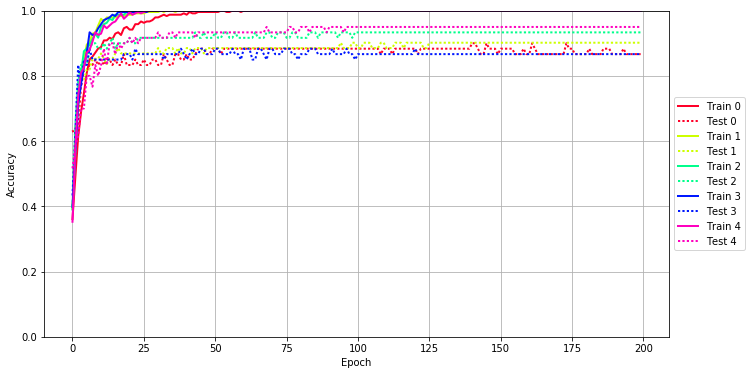

In [18]:
plot_acc(tophistory)

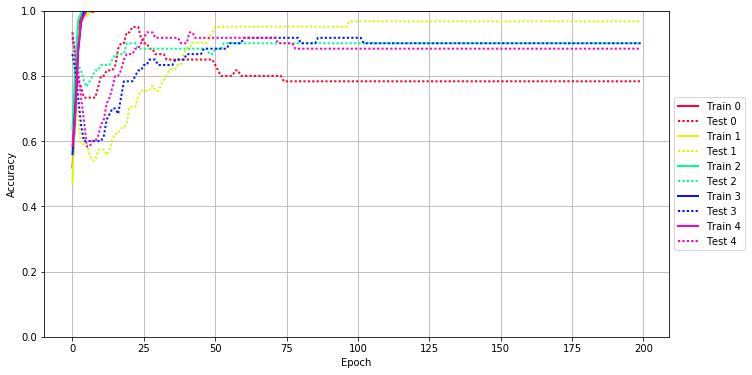

In [19]:
plot_acc(history)

In [20]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

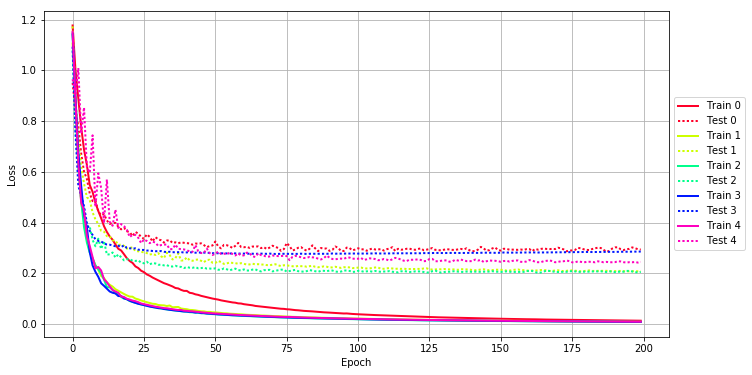

In [21]:
plot_loss(tophistory)

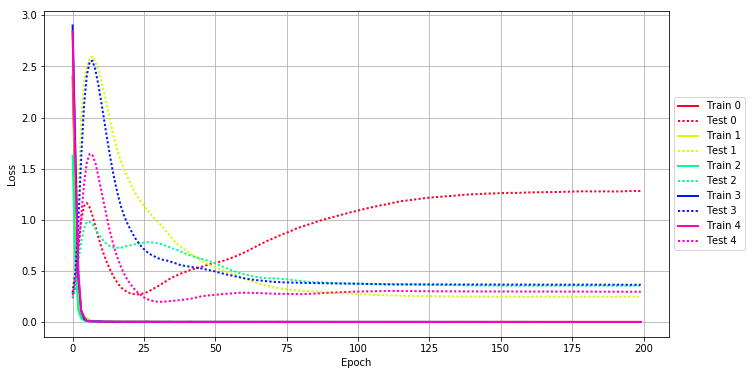

In [22]:
plot_loss(history)

Plotting the confusion matrix


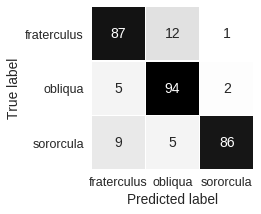

In [23]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


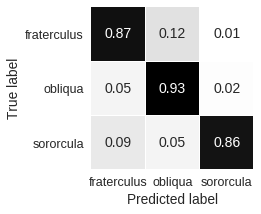

In [24]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
for h in tophistory:
    print(h.history)

{'acc': [0.3609958512407121, 0.48962655107015396, 0.61410787491382901, 0.68879667777738141, 0.74688796433175753, 0.80912862402769536, 0.85062240020862756, 0.85892114945961728, 0.87136928223970023, 0.88381741897693811, 0.88796679483904384, 0.90871367464421693, 0.90871368255852669, 0.91701243378809383, 0.91286305223757791, 0.92946056854675418, 0.93360996048480149, 0.92531119293197062, 0.94605807100588846, 0.95020745873945878, 0.94190870553131423, 0.94190870553131423, 0.95850621392618074, 0.95850620972170375, 0.96680497925311204, 0.96265558137933249, 0.96680497109148023, 0.96680497925311204, 0.97095433656605445, 0.97925311203319498, 0.97925310189298576, 0.98340247948634674, 0.98755186721991706, 0.98340247948634674, 0.98755186721991706, 0.98755184693949849, 0.98755186721991706, 0.98755186721991706, 0.98755184693949849, 0.9917012346730687, 0.98755186721991706, 0.99585062438521643, 0.9917012346730687, 0.99170124481327804, 0.99585062240663902, 0.99585061226642968, 0.99585062240663902, 0.99585

In [26]:
for h in history:
    print(h.history)

{'acc': [0.51867219224510352, 0.68049792283798149, 0.93360996048480149, 0.98755186721991706, 0.99585062240663902, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [27]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

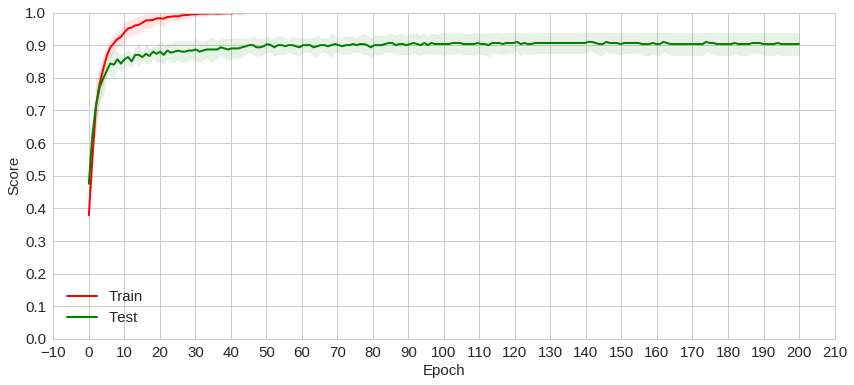

In [28]:
plot_mean_acc(tophistory)

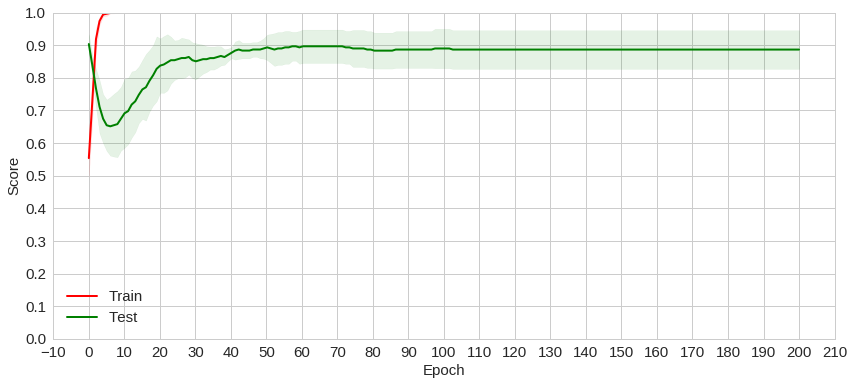

In [29]:
plot_mean_acc(history)

In [30]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

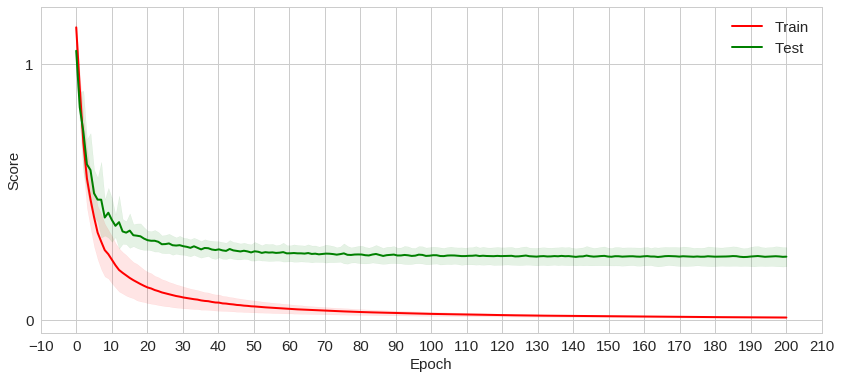

In [31]:
plot_mean_loss(tophistory)

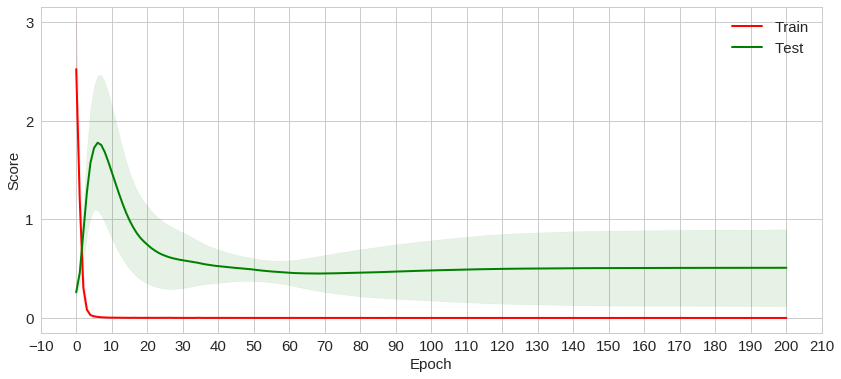

In [32]:
plot_mean_loss(history)

In [34]:
tophist = [{'acc': [0.3609958512407121, 0.48962655107015396, 0.61410787491382901, 0.68879667777738141, 0.74688796433175753, 0.80912862402769536, 0.85062240020862756, 0.85892114945961728, 0.87136928223970023, 0.88381741897693811, 0.88796679483904384, 0.90871367464421693, 0.90871368255852669, 0.91701243378809383, 0.91286305223757791, 0.92946056854675418, 0.93360996048480149, 0.92531119293197062, 0.94605807100588846, 0.95020745873945878, 0.94190870553131423, 0.94190870553131423, 0.95850621392618074, 0.95850620972170375, 0.96680497925311204, 0.96265558137933249, 0.96680497109148023, 0.96680497925311204, 0.97095433656605445, 0.97925311203319498, 0.97925310189298576, 0.98340247948634674, 0.98755186721991706, 0.98340247948634674, 0.98755186721991706, 0.98755184693949849, 0.98755186721991706, 0.98755186721991706, 0.98755184693949849, 0.9917012346730687, 0.98755186721991706, 0.99585062438521643, 0.9917012346730687, 0.99170124481327804, 0.99585062240663902, 0.99585061226642968, 0.99585062240663902, 0.99585062438521643, 0.99585062240663902, 0.99585062240663902, 0.99585062240663902, 0.99585062240663902, 1.0, 1.0, 0.99585062240663902, 0.99585062240663902, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.1765881514648184, 1.001503097565837, 0.89083029199932617, 0.77656913001507644, 0.68721677925576807, 0.62738927345552875, 0.5483900887342904, 0.52117012101090299, 0.47770205832615925, 0.44576054440494395, 0.41742454623780312, 0.38617038739172749, 0.36333396301229959, 0.34562314768549812, 0.33270049812388125, 0.31419261486203837, 0.29705298218984327, 0.29036850306008366, 0.27560479339227639, 0.25986673587090742, 0.24883862587920857, 0.24145071424883927, 0.22766166022704351, 0.22121394267962682, 0.21061894693315275, 0.205056772748959, 0.19610784440861698, 0.19090442328532206, 0.18388309784202655, 0.17845340345163069, 0.17298783003294615, 0.1671389782824457, 0.16167875660652936, 0.15784198416713857, 0.15317297377527006, 0.14877857917077314, 0.14261748508793684, 0.14089615228759797, 0.13511856722633869, 0.13126318707011053, 0.13115523835930093, 0.12375279655100399, 0.12185618714178252, 0.11771120798785657, 0.11549706225325952, 0.11174003347074342, 0.10899834412138491, 0.10618482820720593, 0.10369356928771957, 0.10102098085820922, 0.099172185256273415, 0.096923303369169905, 0.093946896864418178, 0.091928935149893226, 0.08961674883281541, 0.088245568371907307, 0.085832447431888823, 0.084698856618889137, 0.082103903115537655, 0.081473702031547107, 0.078875135893148998, 0.077313005058597228, 0.075388625727896869, 0.074419328285945399, 0.072011365466345401, 0.070760587809986092, 0.069492617645204313, 0.068017472246375818, 0.066720069907760221, 0.065443182727360633, 0.064461116103215838, 0.063233446499866078, 0.061938990402147481, 0.060886854081727657, 0.060432537833684706, 0.058888734221705756, 0.058208336844978489, 0.056704061221779629, 0.055561932228907512, 0.054816941471762679, 0.053582802353063556, 0.052535669978599826, 0.051992810458810497, 0.051068479388457613, 0.050529514002725789, 0.049519092617440523, 0.048674288256039755, 0.04779279865788226, 0.046815918441630001, 0.046398783651377652, 0.045667767772041415, 0.044915927844547135, 0.044230861473380283, 0.043708103109939465, 0.042598039004565276, 0.042205947965259866, 0.042447293355009866, 0.041368136576597124, 0.040450046140375971, 0.039702971879377408, 0.039178605458053808, 0.038766329250147731, 0.037942491208987614, 0.037629607353838648, 0.037014070681887543, 0.036385249856596663, 0.036036750773176612, 0.035617903369590947, 0.03535594200692236, 0.034728235228922356, 0.034692315918034046, 0.033879820721154391, 0.033489148754672883, 0.03316337668580386, 0.032371936852877564, 0.032080495227669287, 0.031572797579142067, 0.031151130192631014, 0.03063723285725008, 0.03052770017155473, 0.029922820774536906, 0.029701566037671694, 0.029416362774322635, 0.028882200756260964, 0.028530908655761682, 0.028223291920552115, 0.027972323657689747, 0.027510662783416476, 0.02718449290455377, 0.026903216800501732, 0.026584012086089716, 0.026278388365732187, 0.026212202137745763, 0.025625787227109259, 0.025491439161582606, 0.02509068878545306, 0.024832376476021722, 0.024567250239651232, 0.024435114069103699, 0.02405607029486494, 0.023773654476117297, 0.023565963884483235, 0.023318349650415644, 0.023094707203418389, 0.023028616387690746, 0.022689524837054654, 0.022286704807113315, 0.022124385909482652, 0.021984871956075375, 0.021823401922259587, 0.021531394949468836, 0.02123928641228013, 0.021019004919098621, 0.020827356169456267, 0.020565790209254534, 0.020398795813383899, 0.020136112084465401, 0.020055976321464754, 0.019863730443340121, 0.019628850905479733, 0.019564823769187532, 0.019358344051476829, 0.019201823630026267, 0.018898893928317607, 0.018691500687500254, 0.018528824200645028, 0.018318181563771612, 0.018186139452939707, 0.018006835511549382, 0.017854119075222628, 0.017718696263444869, 0.017520866275637478, 0.017358674602080678, 0.017174508839969318, 0.017160256628982754, 0.016916758183745429, 0.016840398798530526, 0.016674049716458281, 0.016485321679426922, 0.016327742031191889, 0.016159149033647357, 0.016080165428739367, 0.015889717505556913, 0.015750714411564882, 0.015659003058657112, 0.015546857394834525, 0.01531718746291404, 0.015399225249391869, 0.015209267000934395, 0.014998955706219456, 0.014875307427989743, 0.014774584756290765, 0.01464730338096866, 0.014515153924582904, 0.014432229341251226, 0.014277474135469599, 0.014260791473987192, 0.01408874221470717, 0.013946879979733115, 0.013831534581374825], 'val_acc': [0.63333338499069214, 0.61666673421859741, 0.65000009536743164, 0.76666676998138428, 0.81666672229766846, 0.81666672229766846, 0.83333337306976318, 0.83333337306976318, 0.85000002384185791, 0.83333337306976318, 0.85000002384185791, 0.83333337306976318, 0.85000002384185791, 0.85000002384185791, 0.83333337306976318, 0.85000002384185791, 0.83333337306976318, 0.83333337306976318, 0.86666673421859741, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.85000002384185791, 0.83333337306976318, 0.83333337306976318, 0.85000002384185791, 0.83333337306976318, 0.83333337306976318, 0.85000002384185791, 0.85000002384185791, 0.83333337306976318, 0.83333337306976318, 0.86666667461395264, 0.85000002384185791, 0.83333337306976318, 0.83333337306976318, 0.86666667461395264, 0.86666667461395264, 0.85000002384185791, 0.85000002384185791, 0.86666667461395264, 0.85000008344650269, 0.85000002384185791, 0.86666667461395264, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666667461395264, 0.86666667461395264, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666667461395264, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.90000009536743164, 0.90000009536743164, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.90000009536743164, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.88333344459533691, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.90000009536743164, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.90000009536743164, 0.88333344459533691, 0.88333344459533691, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333344459533691, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333344459533691, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741], 'val_loss': [0.95085406303405762, 0.84146124124526978, 0.78059577941894531, 0.67261797189712524, 0.60069990158081055, 0.57182443141937256, 0.5152275562286377, 0.48468887805938721, 0.48728552460670471, 0.44480156898498535, 0.42879301309585571, 0.43356829881668091, 0.40888828039169312, 0.39474290609359741, 0.39822947978973389, 0.39893102645874023, 0.38382834196090698, 0.37367117404937744, 0.37957286834716797, 0.36612030863761902, 0.36232557892799377, 0.34739956259727478, 0.36320105195045471, 0.35702982544898987, 0.34344398975372314, 0.33638095855712891, 0.35405004024505615, 0.3439880907535553, 0.32581984996795654, 0.34274029731750488, 0.33431482315063477, 0.33042478561401367, 0.32134166359901428, 0.32949143648147583, 0.3308500349521637, 0.32006090879440308, 0.3224252462387085, 0.31868922710418701, 0.32256120443344116, 0.32061946392059326, 0.31940162181854248, 0.31804993748664856, 0.31311902403831482, 0.31752368807792664, 0.31738883256912231, 0.31854677200317383, 0.31161177158355713, 0.30352446436882019, 0.30784577131271362, 0.31015151739120483, 0.3258708119392395, 0.30626216530799866, 0.29880803823471069, 0.31253603100776672, 0.31122332811355591, 0.30683255195617676, 0.30033409595489502, 0.30886158347129822, 0.32003235816955566, 0.30393427610397339, 0.30315756797790527, 0.30457007884979248, 0.30058440566062927, 0.3059084415435791, 0.30582934617996216, 0.30634573101997375, 0.29975467920303345, 0.30327549576759338, 0.29633164405822754, 0.30167239904403687, 0.30912747979164124, 0.30490630865097046, 0.30027481913566589, 0.28902038931846619, 0.29577440023422241, 0.31985163688659668, 0.30756884813308716, 0.29030090570449829, 0.29397052526473999, 0.30109122395515442, 0.30378866195678711, 0.29495829343795776, 0.28943872451782227, 0.29707661271095276, 0.31067240238189697, 0.2983727753162384, 0.28777506947517395, 0.30009591579437256, 0.29849061369895935, 0.29777342081069946, 0.2887130081653595, 0.29281055927276611, 0.3060092031955719, 0.3008609414100647, 0.28856861591339111, 0.28855150938034058, 0.30169415473937988, 0.29986485838890076, 0.29096919298171997, 0.29423600435256958, 0.29901289939880371, 0.29544493556022644, 0.29442232847213745, 0.28935778141021729, 0.29472962021827698, 0.29797846078872681, 0.29416853189468384, 0.29465171694755554, 0.29541060328483582, 0.29001504182815552, 0.29515853524208069, 0.29824647307395935, 0.30325627326965332, 0.28828877210617065, 0.29697415232658386, 0.29351818561553955, 0.29412704706192017, 0.2971709668636322, 0.2977677583694458, 0.29387450218200684, 0.29322820901870728, 0.29644203186035156, 0.29856836795806885, 0.29104220867156982, 0.29350021481513977, 0.29645568132400513, 0.30006241798400879, 0.29305219650268555, 0.29177972674369812, 0.29078724980354309, 0.29340574145317078, 0.29564464092254639, 0.29432883858680725, 0.29284179210662842, 0.29246026277542114, 0.29472887516021729, 0.29651588201522827, 0.2944905161857605, 0.29900917410850525, 0.2913433313369751, 0.28680917620658875, 0.28879621624946594, 0.29381757974624634, 0.30450877547264099, 0.29813504219055176, 0.28990089893341064, 0.29191321134567261, 0.29847580194473267, 0.30226370692253113, 0.29225164651870728, 0.29010003805160522, 0.29720097780227661, 0.29653093218803406, 0.29356050491333008, 0.29376876354217529, 0.29342210292816162, 0.29295501112937927, 0.29412147402763367, 0.29279881715774536, 0.29562169313430786, 0.29593187570571899, 0.28768715262413025, 0.2965051531791687, 0.29366269707679749, 0.29653787612915039, 0.29818540811538696, 0.29648452997207642, 0.2959020733833313, 0.29666322469711304, 0.29597985744476318, 0.30136296153068542, 0.29887914657592773, 0.29455912113189697, 0.28731262683868408, 0.29026636481285095, 0.29067224264144897, 0.29270130395889282, 0.30069291591644287, 0.29892930388450623, 0.29522809386253357, 0.2928568422794342, 0.29204550385475159, 0.29610055685043335, 0.29912447929382324, 0.30139598250389099, 0.30014047026634216, 0.29256939888000488, 0.28538188338279724, 0.28892672061920166, 0.29794010519981384, 0.30257195234298706, 0.30293369293212891, 0.29493576288223267, 0.29202458262443542, 0.29570880532264709, 0.2967623770236969, 0.30251967906951904, 0.2993721067905426, 0.29528665542602539, 0.29390481114387512]},
{'acc': [0.39166666666666666, 0.55833333333333335, 0.74583334525426226, 0.81666667461395259, 0.85416667461395268, 0.89583333730697634, 0.90416668256123855, 0.9291666666666667, 0.93333333333333335, 0.95416667461395266, 0.97500001589457197, 0.96666668256123855, 0.97916668256123862, 0.9791666706403096, 0.97916668256123862, 0.97916667461395268, 0.98333333333333328, 0.98333333333333328, 0.98333333333333328, 0.98750000000000004, 0.98750000397364301, 0.98750000000000004, 0.9916666666666667, 0.99166668256123858, 0.9916666666666667, 0.9916666666666667, 0.99583333333333335, 0.99583333730697632, 0.99583334922790523, 0.99583333730697632, 0.99583333333333335, 1.0, 0.99583334922790523, 1.0, 1.0, 1.0, 0.99583333333333335, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.1052094459533692, 0.89516162872314453, 0.64507472117741904, 0.48058594862620035, 0.41017889777819316, 0.33487921357154848, 0.2869795064131419, 0.25926317771275836, 0.23208780090014139, 0.21424466073513032, 0.18975939253966015, 0.18168466091156005, 0.16521660486857095, 0.15515591998895009, 0.14838661154111227, 0.13770839373270671, 0.13180008381605149, 0.12538740535577139, 0.11916478375593821, 0.1134019802014033, 0.1089081327120463, 0.10834128757317861, 0.10094126164913178, 0.097804755965868628, 0.093375727037588757, 0.089876317481199897, 0.086723025639851889, 0.083506861329078669, 0.080500034491221104, 0.079652484754721323, 0.075749912858009333, 0.07464877168337504, 0.074185006817181903, 0.071657827496528631, 0.073630695541699723, 0.066566156347592678, 0.067548000812530512, 0.067854212969541555, 0.061810035010178885, 0.060207219421863557, 0.059128265579541525, 0.05628771483898163, 0.055892378091812134, 0.05459089974562327, 0.052421011527379352, 0.050895480066537858, 0.050708017001549401, 0.048318614313999815, 0.048658655832211177, 0.046828977018594745, 0.046646665036678317, 0.04539889469742775, 0.044321149090925854, 0.043069134155909218, 0.042860887447992962, 0.041484358906745913, 0.041121229529380798, 0.040330563485622403, 0.039351294686396913, 0.039056045313676201, 0.038104590152700742, 0.037208496530850725, 0.036862400919198991, 0.036234447360038759, 0.035773811986049016, 0.034867604076862332, 0.034304678564270337, 0.034131652365128197, 0.033469159404436746, 0.03292721522351106, 0.032180273036162062, 0.031856181720892586, 0.031763910998900732, 0.031063043326139451, 0.03055706024169922, 0.029967993622024854, 0.029536181688308717, 0.029158423592646917, 0.028788632402817409, 0.028443514431516329, 0.028139983614285786, 0.027535793185234071, 0.027440993984540304, 0.02690335512161255, 0.026916065067052842, 0.02653810034195582, 0.025874130924542747, 0.025547497471173606, 0.025154124945402145, 0.024929476529359819, 0.024655780568718911, 0.02427593767642975, 0.024239206562439601, 0.023724459608395896, 0.023564118146896362, 0.023301251108447711, 0.022939003507296243, 0.022672421733538308, 0.022427023947238924, 0.022238980357845623, 0.021979703505833944, 0.021764884392420452, 0.021442400415738423, 0.021224576234817504, 0.021026937539378801, 0.020689463615417479, 0.020466556151707966, 0.020458203305800757, 0.020280598600705465, 0.019941366712252297, 0.019805690894524258, 0.019564417749643327, 0.019338360428810118, 0.019126527135570844, 0.018927114953597387, 0.018702571590741474, 0.018572780986626944, 0.018447190523147583, 0.018247877433896064, 0.018007817367712658, 0.017809893190860748, 0.017653877536455791, 0.017568052063385645, 0.017262124766906101, 0.017344558611512184, 0.017152019652227561, 0.016852656627694765, 0.016718863199154537, 0.016565716639161111, 0.016393413022160529, 0.016394954423109689, 0.016130210707585017, 0.015989198970297974, 0.015865308418869972, 0.01566062532365322, 0.015551204668978851, 0.01544054684539636, 0.015325588857134182, 0.015128338585297267, 0.015082616421083609, 0.014884398008386293, 0.014764136386414368, 0.014645021284619968, 0.014512636760870615, 0.014396842693289121, 0.014373013625542323, 0.014201109359661738, 0.014038638211786747, 0.013956465013325214, 0.01383547019213438, 0.013756147647897402, 0.013637339447935421, 0.0136444844926397, 0.013437228898207346, 0.01327196719745795, 0.01315650927523772, 0.013118201990922292, 0.013029541137317817, 0.012879107147455215, 0.012785591619710128, 0.012699233119686444, 0.012602662046750387, 0.012512360140681267, 0.012405650814374287, 0.012305592745542526, 0.012225483978788058, 0.012126461292306582, 0.012083012238144874, 0.011965836708744368, 0.011886831745505333, 0.011818255856633186, 0.011694766953587532, 0.011622677991787593, 0.011543750887115796, 0.011482574666539827, 0.011379337993760903, 0.01130978496124347, 0.01121165274331967, 0.011158526067932446, 0.011071233078837395, 0.010983081037799517, 0.010936700366437435, 0.010916796574989954, 0.01075032278895378, 0.010674010155101617, 0.010606064150730768, 0.010538020730018615, 0.010486796932915847, 0.01038576823969682, 0.010335767082870007, 0.010297973950703939, 0.010202330475052198, 0.010154323776563008, 0.010075646732002497, 0.010014207971592744, 0.0099860349049170818, 0.0099283206587036446, 0.0098296071713169422, 0.0097325863316655159, 0.0096996753166119255], 'val_acc': [0.39344260096549988, 0.63934421539306641, 0.68852454423904419, 0.78688520193099976, 0.78688520193099976, 0.8196721076965332, 0.8196721076965332, 0.85245895385742188, 0.85245895385742188, 0.85245895385742188, 0.86885237693786621, 0.85245895385742188, 0.83606553077697754, 0.85245895385742188, 0.85245895385742188, 0.86885237693786621, 0.88524585962295532, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.86885237693786621, 0.88524585962295532, 0.86885237693786621, 0.86885237693786621, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.86885237693786621, 0.88524585962295532, 0.86885237693786621, 0.86885237693786621, 0.88524585962295532, 0.88524585962295532, 0.86885237693786621, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.86885237693786621, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.90163928270339966, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.90163928270339966, 0.90163928270339966, 0.88524585962295532, 0.88524585962295532, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.90163928270339966, 0.90163928270339966, 0.88524585962295532, 0.88524585962295532, 0.88524585962295532, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.88524585962295532, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.88524585962295532, 0.88524585962295532, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966], 'val_loss': [1.1730899810791016, 0.89302825927734375, 0.72596246004104614, 0.6205751895904541, 0.55419933795928955, 0.50026857852935791, 0.48969638347625732, 0.44013869762420654, 0.41262733936309814, 0.39435416460037231, 0.36795538663864136, 0.36462196707725525, 0.3467450737953186, 0.34564530849456787, 0.330463707447052, 0.32950401306152344, 0.31170636415481567, 0.31392145156860352, 0.3087325394153595, 0.29788371920585632, 0.30084764957427979, 0.30249747633934021, 0.28783726692199707, 0.28726938366889954, 0.28458625078201294, 0.28325548768043518, 0.28003180027008057, 0.27431103587150574, 0.27677217125892639, 0.27260947227478027, 0.27983373403549194, 0.26722425222396851, 0.26056510210037231, 0.28175026178359985, 0.27220401167869568, 0.25500157475471497, 0.2601306140422821, 0.27926439046859741, 0.25110495090484619, 0.25099632143974304, 0.26338538527488708, 0.25197687745094299, 0.2498694509267807, 0.25364017486572266, 0.25501057505607605, 0.24957427382469177, 0.24457088112831116, 0.25303316116333008, 0.25402820110321045, 0.24175776541233063, 0.24132956564426422, 0.24919983744621277, 0.24477183818817139, 0.2374764084815979, 0.23913590610027313, 0.243337482213974, 0.24144122004508972, 0.24048526585102081, 0.23807111382484436, 0.24039512872695923, 0.23782163858413696, 0.23518726229667664, 0.23545338213443756, 0.2383543848991394, 0.23570391535758972, 0.23645950853824615, 0.23503890633583069, 0.23480220139026642, 0.23276530206203461, 0.23215149343013763, 0.23460511863231659, 0.23623974621295929, 0.23191837966442108, 0.22895027697086334, 0.23220065236091614, 0.23182712495326996, 0.22984398901462555, 0.22830282151699066, 0.2272375077009201, 0.22962081432342529, 0.22851540148258209, 0.2286020815372467, 0.22650045156478882, 0.22854959964752197, 0.22998027503490448, 0.2259991317987442, 0.22437046468257904, 0.22578653693199158, 0.22777575254440308, 0.22644366323947906, 0.22318646311759949, 0.22405992448329926, 0.22631560266017914, 0.2240789532661438, 0.22174149751663208, 0.22431114315986633, 0.22469295561313629, 0.22376865148544312, 0.2211654931306839, 0.2211921364068985, 0.22299042344093323, 0.22315187752246857, 0.2202947586774826, 0.21957707405090332, 0.21980574727058411, 0.22171564400196075, 0.22346954047679901, 0.22345653176307678, 0.21802762150764465, 0.21835370361804962, 0.22009864449501038, 0.22100526094436646, 0.21931171417236328, 0.21795654296875, 0.21894705295562744, 0.21779900789260864, 0.21909105777740479, 0.21701714396476746, 0.21753445267677307, 0.21740493178367615, 0.21739962697029114, 0.21791297197341919, 0.21746456623077393, 0.21957892179489136, 0.22013439238071442, 0.2163669615983963, 0.21537499129772186, 0.21585750579833984, 0.21623271703720093, 0.21637105941772461, 0.21749451756477356, 0.21642960608005524, 0.21594974398612976, 0.21646729111671448, 0.21491774916648865, 0.21432876586914062, 0.21696169674396515, 0.21642091870307922, 0.21560952067375183, 0.21512164175510406, 0.21348576247692108, 0.21253600716590881, 0.21346560120582581, 0.21566718816757202, 0.21627359092235565, 0.21436449885368347, 0.21218311786651611, 0.21298938989639282, 0.21474312245845795, 0.2144942581653595, 0.21435827016830444, 0.21332797408103943, 0.21108266711235046, 0.2113933265209198, 0.2132989913225174, 0.21480868756771088, 0.21569564938545227, 0.21311955153942108, 0.2127678245306015, 0.21147415041923523, 0.21084378659725189, 0.21151784062385559, 0.21142786741256714, 0.21186254918575287, 0.21345348656177521, 0.21335487067699432, 0.21220864355564117, 0.20963987708091736, 0.20999857783317566, 0.2117139995098114, 0.21246093511581421, 0.21000981330871582, 0.209074467420578, 0.2101229727268219, 0.2118925005197525, 0.21198040246963501, 0.21083524823188782, 0.20956146717071533, 0.20826417207717896, 0.20909018814563751, 0.21098944544792175, 0.2118203192949295, 0.20982994139194489, 0.20991605520248413, 0.21029472351074219, 0.21000492572784424, 0.2097548246383667, 0.210309699177742, 0.20892515778541565, 0.20810060203075409, 0.2091180682182312, 0.20973531901836395, 0.20989131927490234, 0.20885863900184631, 0.20785057544708252, 0.20840808749198914, 0.20873381197452545, 0.20877034962177277, 0.20842866599559784, 0.20821982622146606]},
{'acc': [0.39004149080806749, 0.58091286851162738, 0.75518671556132466, 0.80912862427501753, 0.87551865785448379, 0.88381741304120587, 0.89626555596149804, 0.91286305421615532, 0.92946056261102195, 0.91701243774524865, 0.95020744859924955, 0.95850620774312634, 0.96265559151954172, 0.97510372627820219, 0.97095435882505043, 0.98755186721991706, 0.98755186721991706, 0.98755184693949849, 0.98755186721991706, 0.99585062240663902, 0.99585062240663902, 0.99585062438521643, 0.99585061226642968, 0.99585062240663902, 0.99585062240663902, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.1398162035526576, 0.86614376182872721, 0.61492423496800341, 0.48651260533273466, 0.38282049345277652, 0.32167910008509626, 0.28181230403575658, 0.25881231251593945, 0.23132751393614964, 0.21641264738383628, 0.20043407522791154, 0.17569503515835125, 0.14623136218652685, 0.14566528580742752, 0.13559945094634884, 0.12235880027915433, 0.11783221883397874, 0.10739636025488129, 0.1006575166189819, 0.098945615759034378, 0.091233091853960918, 0.087821757150388854, 0.084493374119655726, 0.080993766977579262, 0.077751208050369724, 0.075291117351826795, 0.073691685664703244, 0.070964329037428886, 0.067617828188719101, 0.065862519241467549, 0.063783461003877315, 0.061327663169114914, 0.060646510779610315, 0.058168964081780052, 0.056659336746728274, 0.055462218851964007, 0.05392224588953113, 0.052757962919864419, 0.051333804039044993, 0.049957991983447823, 0.049509430543763014, 0.047324577338715312, 0.046666492070399877, 0.046121702680201944, 0.044600440212428816, 0.043536799268109175, 0.043047581764548648, 0.041727272167616368, 0.040658873254703784, 0.039783738337117111, 0.039707116102529263, 0.038277985798620087, 0.037738798719471424, 0.037558144105296905, 0.036678944076739904, 0.035786079961605585, 0.035012699771842522, 0.034719600299705611, 0.033865791262432748, 0.033211192154785407, 0.033170121663957219, 0.032168360079225168, 0.031700205892571769, 0.031127360939237587, 0.030852410826383785, 0.030046735438073818, 0.029799181218278358, 0.029357147770180246, 0.028723576195012486, 0.028425700328780407, 0.028214006935907102, 0.027637254987762181, 0.027090257706112883, 0.026809795276567155, 0.026694506453156967, 0.026509076619667633, 0.025750782371680273, 0.025322914278111518, 0.0251883537628344, 0.024725695615982118, 0.024361338559151687, 0.024080004589438934, 0.023848746203782648, 0.023711219522715606, 0.023100257538166285, 0.022858692240356408, 0.022617670123878851, 0.022494546837208182, 0.022103310334670098, 0.021811080710089057, 0.021526106505720448, 0.021374582030899297, 0.021019952070292596, 0.020815285989295891, 0.020748350637891481, 0.020420711703938568, 0.020257375755683513, 0.020033447296045628, 0.019796107412621194, 0.01948830984625579, 0.019314100888569326, 0.019045272061438977, 0.018914512447487271, 0.018596179706056089, 0.018435838118319194, 0.018286779561539904, 0.018115353024723124, 0.017842144175931132, 0.017730746402780051, 0.017524686228499373, 0.017371400116452045, 0.01732757340931175, 0.016954866906481163, 0.017023527469192303, 0.016760854436957986, 0.016562913610170985, 0.016598747563992794, 0.016305420779588312, 0.016214202239305645, 0.016003184553807701, 0.015755524116865826, 0.015639542134409129, 0.015486505245828529, 0.015310423410037742, 0.015287951230075349, 0.01511364278704299, 0.014922776329041269, 0.014854781360547077, 0.01470201442412321, 0.014588456229921198, 0.014498532023203571, 0.014334202744066715, 0.014180407720266288, 0.014035052302992937, 0.01398128873564272, 0.01383005744194094, 0.013690215690038263, 0.013612303001752039, 0.013475065494412209, 0.013382132385405268, 0.01331960363893217, 0.01317310721238619, 0.013069415619573652, 0.012983677669184832, 0.012844070842435499, 0.012742370162236493, 0.012628462374272188, 0.012537670561355921, 0.012451588473750348, 0.012359074985461611, 0.012252785914666425, 0.012156641338777988, 0.012082830855924312, 0.011969982762337968, 0.011894140523931793, 0.011823924018757967, 0.011719851433859821, 0.011683245734369607, 0.011586493538128391, 0.011463114945411187, 0.011432952216644752, 0.01136261427241737, 0.011184064856888842, 0.011217508689187375, 0.011160760453256828, 0.010954594834711541, 0.01091746851430889, 0.010894147996091249, 0.010783767258106921, 0.010670203761935729, 0.010614467688152157, 0.010551128316191469, 0.010461540189397781, 0.010396240047213942, 0.01035371624876231, 0.010252702780284327, 0.01017277623252379, 0.010120468299171242, 0.010055577861632053, 0.010030086704866025, 0.0099192370865416723, 0.0098869287335464576, 0.0097892322573671694, 0.0097177559007500212, 0.0096669642764812182, 0.0096010756814133569, 0.009579241538567167, 0.0094800881376775961, 0.0094342305096971543, 0.0093471048345704303, 0.0093277162056864538, 0.0092307478112180208, 0.0091783394070952765, 0.0091281192439040208, 0.0090950630079661161, 0.0090160735987157743, 0.008954541031193931, 0.0088967255266437385, 0.0088636733947082182, 0.0088153245793153139], 'val_acc': [0.40000000596046448, 0.65000009536743164, 0.783333420753479, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.88333338499069214, 0.90000009536743164, 0.90000009536743164, 0.88333338499069214, 0.88333338499069214, 0.90000003576278687, 0.88333338499069214, 0.90000009536743164, 0.91666674613952637, 0.88333338499069214, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.91666674613952637, 0.90000009536743164, 0.90000009536743164, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109], 'val_loss': [1.0789229869842529, 0.76354753971099854, 0.62286245822906494, 0.49186483025550842, 0.45768660306930542, 0.38753026723861694, 0.38440939784049988, 0.33203530311584473, 0.30700013041496277, 0.33681923151016235, 0.29614549875259399, 0.32793122529983521, 0.27408158779144287, 0.27541041374206543, 0.28241494297981262, 0.26233154535293579, 0.27471446990966797, 0.26381233334541321, 0.25167635083198547, 0.25608068704605103, 0.25597408413887024, 0.25013190507888794, 0.24917690455913544, 0.25151684880256653, 0.24232742190361023, 0.23988978564739227, 0.24611212313175201, 0.23577776551246643, 0.24089318513870239, 0.23926840722560883, 0.23428678512573242, 0.23416218161582947, 0.2317044734954834, 0.23275630176067352, 0.22765079140663147, 0.22726790606975555, 0.23016953468322754, 0.2264162003993988, 0.22577923536300659, 0.22103095054626465, 0.22526904940605164, 0.22255206108093262, 0.22205519676208496, 0.22491881251335144, 0.22007368505001068, 0.22103673219680786, 0.22304151952266693, 0.218888059258461, 0.21925684809684753, 0.21817941963672638, 0.22003811597824097, 0.21464836597442627, 0.214227095246315, 0.21975554525852203, 0.21639198064804077, 0.21212413907051086, 0.21603655815124512, 0.21877053380012512, 0.21312898397445679, 0.21166834235191345, 0.21579349040985107, 0.21143844723701477, 0.21144212782382965, 0.21507269144058228, 0.21623392403125763, 0.21048173308372498, 0.20797398686408997, 0.21274212002754211, 0.21360313892364502, 0.21424447000026703, 0.20801715552806854, 0.21040573716163635, 0.21255007386207581, 0.21475459635257721, 0.21506254374980927, 0.20687748491764069, 0.20947319269180298, 0.2119852751493454, 0.21389174461364746, 0.20869562029838562, 0.20789368450641632, 0.2068297266960144, 0.20899049937725067, 0.21330118179321289, 0.21082419157028198, 0.20800340175628662, 0.20629465579986572, 0.21051056683063507, 0.21031923592090607, 0.20871089398860931, 0.21136662364006042, 0.21135863661766052, 0.2075406014919281, 0.20620344579219818, 0.20725835859775543, 0.21158879995346069, 0.21137914061546326, 0.20986777544021606, 0.20589143037796021, 0.20678795874118805, 0.21023315191268921, 0.20953294634819031, 0.20644965767860413, 0.20820161700248718, 0.20926558971405029, 0.20667397975921631, 0.20963652431964874, 0.20738057792186737, 0.20645852386951447, 0.20747657120227814, 0.207985520362854, 0.2090105414390564, 0.20664244890213013, 0.20533610880374908, 0.20416006445884705, 0.20800390839576721, 0.2094184011220932, 0.2075311541557312, 0.2059493362903595, 0.20605748891830444, 0.20813959836959839, 0.20816126465797424, 0.20780658721923828, 0.20564520359039307, 0.20351342856884003, 0.20426125824451447, 0.20875860750675201, 0.21060861647129059, 0.20715624094009399, 0.20339652895927429, 0.20522792637348175, 0.20692862570285797, 0.20666156709194183, 0.2078910768032074, 0.20909775793552399, 0.20706689357757568, 0.20624229311943054, 0.20560233294963837, 0.20737598836421967, 0.20769703388214111, 0.20570556819438934, 0.20713542401790619, 0.20653069019317627, 0.20631715655326843, 0.20701533555984497, 0.20649129152297974, 0.20776258409023285, 0.20876236259937286, 0.20735272765159607, 0.20680148899555206, 0.20591163635253906, 0.20687328279018402, 0.20812660455703735, 0.20699018239974976, 0.20567008852958679, 0.20603519678115845, 0.20594039559364319, 0.20613408088684082, 0.20625321567058563, 0.20952345430850983, 0.20912392437458038, 0.20962211489677429, 0.20577552914619446, 0.20203655958175659, 0.20361430943012238, 0.20712058246135712, 0.21091310679912567, 0.20994260907173157, 0.20822808146476746, 0.20577195286750793, 0.20568796992301941, 0.20506054162979126, 0.20719519257545471, 0.20639179646968842, 0.20888012647628784, 0.20835244655609131, 0.20798327028751373, 0.20592260360717773, 0.20660179853439331, 0.20703811943531036, 0.20669072866439819, 0.20712441205978394, 0.20754911005496979, 0.20851178467273712, 0.20787690579891205, 0.20855005085468292, 0.20651783049106598, 0.20587912201881409, 0.20805703103542328, 0.20771999657154083, 0.20527392625808716, 0.20663532614707947, 0.20664605498313904, 0.20676973462104797, 0.20991496741771698, 0.20989175140857697, 0.2077333927154541, 0.205108642578125, 0.20401328802108765, 0.20616769790649414]},
{'acc': [0.39834024376888988, 0.56431534972922925, 0.70954357192724082, 0.77593360946386192, 0.82572613069130674, 0.87136927630396799, 0.93360994416153775, 0.92531118303908355, 0.92946056656817677, 0.9460580811460978, 0.95850621392618074, 0.97095435264199603, 0.97510372627820219, 0.97925310387156317, 0.98755186919849447, 0.98340247948634674, 0.99585062240663902, 0.99585062240663902, 0.99585062240663902, 0.99585062240663902, 0.99170124481327804, 0.99585062240663902, 0.99585062240663902, 0.99585062240663902, 1.0, 0.99585062240663902, 0.99585061226642968, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.1448179201466413, 0.89195445538556428, 0.68069158475923341, 0.54585716833217512, 0.43171656811880371, 0.38208042239747109, 0.28414848854927599, 0.23135997750699766, 0.20624340118461626, 0.18655355169565352, 0.16108402838598149, 0.15111947671753737, 0.14026296930194396, 0.12891370688731246, 0.12389028400059063, 0.12117730643739344, 0.11090907108239613, 0.11070576780069913, 0.10253920934754289, 0.098038069687443649, 0.092568218367970342, 0.08775663335664638, 0.084282826833210547, 0.080389218706313006, 0.078057194275480093, 0.075277118205529528, 0.072785377687933042, 0.069464770157307509, 0.0677284677184469, 0.065734840233914585, 0.063245841390859037, 0.063222231706643012, 0.059635083210418827, 0.058728550278670563, 0.056735208435795617, 0.055398483803163423, 0.054107498655799016, 0.052610672175636926, 0.051262275373787303, 0.050227582392850849, 0.049730744367442188, 0.048730521358518679, 0.048033312148572996, 0.045735019974070465, 0.046781298530546959, 0.04380768403039928, 0.043802706594289094, 0.0420794173209499, 0.041727844440219805, 0.040379483639204648, 0.039522783390219279, 0.038920016178698953, 0.038409648053502637, 0.037640265223890912, 0.036795128368737787, 0.035994215903193127, 0.035582559330087478, 0.03508132682239861, 0.034344777619442997, 0.033929661488260966, 0.033422464141583542, 0.032778850891839913, 0.0324349345724365, 0.031867057502393409, 0.031300177959980309, 0.030776572147098318, 0.030376460318186967, 0.029761869228479773, 0.029604091730231565, 0.029332587565005567, 0.028657960346069079, 0.028343797193770587, 0.027755808773067978, 0.027322525691812958, 0.027071843627082856, 0.026662786827418815, 0.026283138535947721, 0.026064624646639924, 0.025665400016480957, 0.025275743771267137, 0.025135119890029006, 0.02472566984810275, 0.024462821418071684, 0.024116995995593762, 0.023763555662389614, 0.023509932689646962, 0.023236650077015534, 0.022913349684157806, 0.022677827881517745, 0.022431112362141431, 0.022191254522543231, 0.022059894441259848, 0.021759238890159675, 0.0213602917322974, 0.021197622896972038, 0.021037926990152396, 0.02069302019180104, 0.020520266825603747, 0.020245805235881032, 0.020146342566337329, 0.019882859213903731, 0.019640097139534615, 0.019472115847023196, 0.019349791016816102, 0.019112029557282501, 0.018856182995859023, 0.018738531349110899, 0.018512661696345974, 0.018262142794693653, 0.01816996765860136, 0.017993937049416587, 0.01781077363771769, 0.017658138384895699, 0.017486546984661171, 0.017286253096033429, 0.017114569158660425, 0.017026435135558432, 0.016801210908659762, 0.016653839104588595, 0.01650066554731848, 0.016467125537608176, 0.016209346593910233, 0.016062135642000253, 0.015967411599682325, 0.015804975374729305, 0.015685683556859426, 0.015593495374522268, 0.015539499648935567, 0.01529340057235783, 0.015131335380908365, 0.015040688545161015, 0.014901565040048227, 0.014740377440430316, 0.014592730084673745, 0.014537444407761838, 0.014417931878034999, 0.014300888682487595, 0.014128473405706932, 0.014039584717624416, 0.01399115780638956, 0.013817657426741608, 0.013710349404032793, 0.013686362244343362, 0.013454590305778743, 0.013399240456490595, 0.013299998019617128, 0.013206921409645515, 0.013066352882202235, 0.013019678074696499, 0.012938779307320653, 0.012807875550912376, 0.012709103540142543, 0.012639830422228302, 0.012555602366004247, 0.01242833753808158, 0.012387693894416464, 0.012237508437321888, 0.012167585047572481, 0.012064380926771777, 0.012009454075695321, 0.011904204117435637, 0.011878315861727192, 0.011710742619893364, 0.011626992734048623, 0.011570173640314227, 0.011478990455509716, 0.011410254181296993, 0.011344577452453835, 0.01125938085553186, 0.011189480211693964, 0.011177744299049695, 0.01101978209750781, 0.010928460547538219, 0.010862738183888904, 0.010819257209966291, 0.010712357199290977, 0.010690670274970938, 0.010630863996925938, 0.010496696897809436, 0.010469884685089975, 0.010437869830095668, 0.010332236342765854, 0.010266152596974521, 0.010244811502482387, 0.010124066311294113, 0.010040338035224632, 0.010025281775974634, 0.0099704885986707029, 0.0098915422775809701, 0.0098967793865198904, 0.0097697620546731215, 0.0096796546131372452, 0.0096311177478724495, 0.0095533770103301257, 0.0095078835913069027, 0.0094523660884976886, 0.0094015719369053841, 0.0093612872736520795, 0.0092754816381392137, 0.0092484209941568717], 'val_acc': [0.43333339691162109, 0.63333338499069214, 0.83333337306976318, 0.7666667103767395, 0.85000002384185791, 0.83333337306976318, 0.88333338499069214, 0.85000008344650269, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.85000002384185791, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.85000008344650269, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.86666673421859741, 0.85000008344650269, 0.86666673421859741, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.85000008344650269, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.85000008344650269, 0.85000008344650269, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.85000008344650269, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.85000008344650269, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.85000008344650269, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741], 'val_loss': [1.0928874015808105, 0.75553512573242188, 0.54476690292358398, 0.50683057308197021, 0.46453180909156799, 0.39815625548362732, 0.3675825297832489, 0.35152804851531982, 0.33452451229095459, 0.32794281840324402, 0.32633125782012939, 0.31738710403442383, 0.31403464078903198, 0.31323349475860596, 0.30998972058296204, 0.30691075325012207, 0.30916497111320496, 0.30371993780136108, 0.31060302257537842, 0.30036970973014832, 0.2989230751991272, 0.29778009653091431, 0.2988007664680481, 0.29355460405349731, 0.29255956411361694, 0.29248011112213135, 0.29017993807792664, 0.28988939523696899, 0.28843119740486145, 0.28754580020904541, 0.28758665919303894, 0.28807279467582703, 0.28538155555725098, 0.28426152467727661, 0.28540250658988953, 0.28382748365402222, 0.2830776572227478, 0.28336632251739502, 0.28408685326576233, 0.28206905722618103, 0.28275623917579651, 0.28358727693557739, 0.28238445520401001, 0.28155547380447388, 0.28250956535339355, 0.28193455934524536, 0.28173571825027466, 0.28188687562942505, 0.28079628944396973, 0.27974167466163635, 0.27952516078948975, 0.27943292260169983, 0.27906125783920288, 0.27906239032745361, 0.27861952781677246, 0.2782551646232605, 0.27851110696792603, 0.2790292501449585, 0.27820450067520142, 0.27776342630386353, 0.2781909704208374, 0.27779722213745117, 0.2778477668762207, 0.27768427133560181, 0.27712413668632507, 0.27755165100097656, 0.27802246809005737, 0.27745682001113892, 0.27720522880554199, 0.2780381441116333, 0.27729508280754089, 0.27666628360748291, 0.27699601650238037, 0.27743762731552124, 0.27742499113082886, 0.27718952298164368, 0.27706485986709595, 0.2772212028503418, 0.27697080373764038, 0.2769586443901062, 0.27774655818939209, 0.27706164121627808, 0.27681881189346313, 0.27743524312973022, 0.27751749753952026, 0.27787333726882935, 0.27737867832183838, 0.27722293138504028, 0.27720332145690918, 0.27732586860656738, 0.27765887975692749, 0.27857059240341187, 0.277751624584198, 0.27786779403686523, 0.2780291736125946, 0.27799880504608154, 0.27835845947265625, 0.27822029590606689, 0.2783224880695343, 0.27845942974090576, 0.27810075879096985, 0.27820217609405518, 0.278329998254776, 0.27807062864303589, 0.27857786417007446, 0.27869588136672974, 0.27923583984375, 0.27846613526344299, 0.27845880389213562, 0.2787015438079834, 0.27865281701087952, 0.27879607677459717, 0.27920463681221008, 0.27916944026947021, 0.27889275550842285, 0.27907562255859375, 0.2792489230632782, 0.2789502739906311, 0.27936834096908569, 0.27955642342567444, 0.28015711903572083, 0.27958264946937561, 0.27947017550468445, 0.28004541993141174, 0.27997368574142456, 0.28000730276107788, 0.28023511171340942, 0.2808775007724762, 0.28058871626853943, 0.28009450435638428, 0.28013938665390015, 0.28063368797302246, 0.28070974349975586, 0.28090333938598633, 0.28083479404449463, 0.28043070435523987, 0.28068047761917114, 0.28064492344856262, 0.28059348464012146, 0.28112947940826416, 0.28090468049049377, 0.28102597594261169, 0.28082999587059021, 0.28131595253944397, 0.28175818920135498, 0.28177738189697266, 0.28165739774703979, 0.28142851591110229, 0.28109085559844971, 0.28121548891067505, 0.28179794549942017, 0.28240972757339478, 0.28241819143295288, 0.28171214461326599, 0.28184959292411804, 0.28162750601768494, 0.28196191787719727, 0.28230994939804077, 0.28259122371673584, 0.28250017762184143, 0.28233367204666138, 0.28276658058166504, 0.28245887160301208, 0.28237920999526978, 0.28253471851348877, 0.28270295262336731, 0.28280919790267944, 0.28310132026672363, 0.28312155604362488, 0.28342127799987793, 0.28326794505119324, 0.28341111540794373, 0.28345084190368652, 0.28351181745529175, 0.28393885493278503, 0.28382539749145508, 0.28388527035713196, 0.2840045690536499, 0.28416001796722412, 0.28450265526771545, 0.28457766771316528, 0.28423571586608887, 0.28426113724708557, 0.28453469276428223, 0.28445065021514893, 0.28447949886322021, 0.28475403785705566, 0.28503504395484924, 0.28501290082931519, 0.28468507528305054, 0.28500393033027649, 0.28510087728500366, 0.28526386618614197, 0.28531628847122192, 0.28526079654693604, 0.28525876998901367, 0.28536885976791382, 0.28568822145462036, 0.28598195314407349, 0.28610357642173767]},
{'acc': [0.35269709222049633, 0.57676348300395663, 0.73858920716645804, 0.80912862823217246, 0.82572613069130674, 0.8713692782825454, 0.87966803940499971, 0.90456430298658819, 0.93360995034459215, 0.9253111909533932, 0.92946056458959936, 0.95435682619261053, 0.94605807496304339, 0.95435682619261053, 0.96265560363832847, 0.96680496095127089, 0.9792531140117724, 0.99170124481327804, 0.97510372627820219, 0.98340248962655596, 0.99585062240663902, 0.98755185707970772, 0.99170124481327804, 0.99585061226642968, 0.99170124481327804, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.1517283293221501, 0.88137385162575121, 0.63685680474483131, 0.47858330273529304, 0.44793992047487946, 0.34641391335681265, 0.30834423456943877, 0.2636954770790591, 0.22011005519831328, 0.22539913679059612, 0.21148380018863441, 0.17719757420888085, 0.16513303812608679, 0.1492558179801925, 0.13464942698162127, 0.12891149916589506, 0.12360218822708763, 0.10917918517010836, 0.10722444722761257, 0.10020493199716465, 0.096905760807120447, 0.093116332973929364, 0.090644047158882329, 0.086859629794769758, 0.081665489946287209, 0.079057494819906246, 0.076693563911430077, 0.073426471072484845, 0.071538212171976007, 0.069196491289682902, 0.06735462890126398, 0.065257522420517147, 0.063419313877202663, 0.062803337620996338, 0.060881093855468069, 0.058828114381222311, 0.057402084075316356, 0.056151580421014445, 0.056425017919159527, 0.05323400187665496, 0.0527666887863543, 0.051388548339303598, 0.050802082673518982, 0.049508247014397905, 0.047894535346644548, 0.047009690266674488, 0.045803093223898243, 0.045163831213697853, 0.043931836718345579, 0.042951541214686709, 0.042231718132357376, 0.041559348029714401, 0.040976684896035807, 0.040026010188015167, 0.039708296571282428, 0.038410452561630747, 0.038076870367549268, 0.03733273598663045, 0.03673096617907904, 0.036161047356257303, 0.035708922058096566, 0.034895585285677454, 0.034453186967808185, 0.033948873057652311, 0.033525183147661911, 0.033095532819566884, 0.032511450829471294, 0.031926639316240284, 0.03170745006735394, 0.030998040794460606, 0.030718601575407251, 0.030162265485624059, 0.029620747464511901, 0.029303353820846288, 0.028845306740942336, 0.028778969159512103, 0.028784453374221614, 0.028161500854981886, 0.027247414294305678, 0.027077445165250312, 0.026709826918187476, 0.026271066941413641, 0.025989364817182059, 0.025757679468430425, 0.025385679793061063, 0.025059146458800897, 0.024756201940948044, 0.024588700468918593, 0.024172803502978131, 0.024080732342675021, 0.023732339012672299, 0.023315449133206205, 0.023122992304721809, 0.02307111615338266, 0.02252855968054894, 0.022600028710246581, 0.022156796267418444, 0.021970029000610236, 0.021731096339176303, 0.021373767761273997, 0.021183753424783961, 0.021054611978009036, 0.020875858568056984, 0.020500261475683741, 0.020290510759870543, 0.020098788114998847, 0.01989046067648656, 0.019718335833230453, 0.019494270890394683, 0.019377616964497014, 0.01912398814876792, 0.019113138905452, 0.018749372562184868, 0.018581780547052004, 0.018509245118226748, 0.018319766025572892, 0.018124554062810924, 0.018120163526092328, 0.017872801089187876, 0.017592033046718948, 0.017408260573242709, 0.017333631770863077, 0.017237298480424396, 0.017071789343111002, 0.016923554906335608, 0.016836446396913767, 0.016694978521016129, 0.01645088556736584, 0.016302833217679218, 0.016177325528810627, 0.016026907936666022, 0.015867732581199452, 0.015763221161741437, 0.015614275770315985, 0.015598451772789738, 0.015384333849695214, 0.015290828398525467, 0.015223821625113487, 0.015041639464153789, 0.014945038014644162, 0.014780734557488399, 0.014676828037839212, 0.014554669013965673, 0.014569188522259972, 0.014448926331962292, 0.014190008744010045, 0.014077662308681061, 0.013967625588116804, 0.01386975433631062, 0.013754619154074379, 0.013736062887978752, 0.0135645765764832, 0.013426877450027901, 0.013426392737204109, 0.01325299477985291, 0.013135672697635112, 0.013055871754761059, 0.013006091488842153, 0.012879068669534571, 0.012758037338180166, 0.012737051340368774, 0.012605355859297439, 0.012523550103530597, 0.01241444128940338, 0.012338802678301869, 0.012249695720668898, 0.012176741857499007, 0.012085559511271255, 0.012011899006131773, 0.012028942754128909, 0.011866338891112459, 0.011754460802835053, 0.011688650284287099, 0.011643261072917598, 0.01156523867792361, 0.011472241732744012, 0.011371987864096877, 0.011356835837062464, 0.011233877328792548, 0.011161578146748523, 0.01111304633226632, 0.011026132496313436, 0.010950075280833294, 0.010919078767175992, 0.010846174314339874, 0.010747652052596398, 0.0106649982561338, 0.010609113986128594, 0.010518994885670693, 0.010479563966980861, 0.010438198239167697, 0.010350476196847268, 0.010282701090040048, 0.010225454128938593, 0.010144474396397093, 0.010083297020234014, 0.010020458599343834, 0.0099632863913705245, 0.0099196264914457235, 0.0098589021341558315], 'val_acc': [0.5166667103767395, 0.58333337306976318, 0.61666673421859741, 0.70000004768371582, 0.70000004768371582, 0.80000007152557373, 0.80000007152557373, 0.76666676998138428, 0.83333337306976318, 0.80000007152557373, 0.83333337306976318, 0.88333338499069214, 0.83333337306976318, 0.90000003576278687, 0.90000003576278687, 0.86666667461395264, 0.90000003576278687, 0.88333332538604736, 0.90000003576278687, 0.90000003576278687, 0.91666668653488159, 0.90000003576278687, 0.91666668653488159, 0.90000003576278687, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.93333339691162109, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.93333339691162109, 0.93333339691162109, 0.91666668653488159, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.91666668653488159, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.95000004768371582, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.95000004768371582, 0.95000004768371582, 0.93333339691162109, 0.93333339691162109, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.93333339691162109, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.93333339691162109, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.93333339691162109, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582], 'val_loss': [0.9645768404006958, 0.90086591243743896, 1.0088679790496826, 0.7506859302520752, 0.85362207889556885, 0.6183922290802002, 0.59688675403594971, 0.74387764930725098, 0.46309894323348999, 0.59410566091537476, 0.53625780344009399, 0.39825376868247986, 0.56981575489044189, 0.40327408909797668, 0.38773787021636963, 0.45094048976898193, 0.37921035289764404, 0.39427125453948975, 0.3866959810256958, 0.37195533514022827, 0.34322303533554077, 0.35221624374389648, 0.35138359665870667, 0.34049338102340698, 0.31953588128089905, 0.33370476961135864, 0.32777541875839233, 0.31922709941864014, 0.32476314902305603, 0.3219357430934906, 0.30787032842636108, 0.31173709034919739, 0.31317538022994995, 0.31417053937911987, 0.29552704095840454, 0.29570215940475464, 0.31356799602508545, 0.29714035987854004, 0.29599112272262573, 0.2944953441619873, 0.29182121157646179, 0.28602442145347595, 0.28497827053070068, 0.3116651177406311, 0.28752017021179199, 0.28020495176315308, 0.2806667685508728, 0.29781010746955872, 0.28045707941055298, 0.27253895998001099, 0.27787289023399353, 0.28619983792304993, 0.27637785673141479, 0.27846497297286987, 0.27414357662200928, 0.28284925222396851, 0.27678793668746948, 0.2707943320274353, 0.27904647588729858, 0.27070635557174683, 0.27099335193634033, 0.28174388408660889, 0.27935677766799927, 0.26758930087089539, 0.26480847597122192, 0.27954179048538208, 0.27216261625289917, 0.26974627375602722, 0.26553785800933838, 0.26681309938430786, 0.27052211761474609, 0.26900124549865723, 0.26830005645751953, 0.26872318983078003, 0.26910760998725891, 0.26823964715003967, 0.25207942724227905, 0.26513940095901489, 0.26935693621635437, 0.26680546998977661, 0.26362884044647217, 0.26072150468826294, 0.26151549816131592, 0.26507455110549927, 0.26330292224884033, 0.26248800754547119, 0.25805175304412842, 0.25503051280975342, 0.26016107201576233, 0.27033361792564392, 0.26178649067878723, 0.25678366422653198, 0.25558340549468994, 0.25758349895477295, 0.25846397876739502, 0.25699380040168762, 0.26303824782371521, 0.26243716478347778, 0.25810033082962036, 0.25774246454238892, 0.25794404745101929, 0.26133278012275696, 0.2529619038105011, 0.25561714172363281, 0.25915920734405518, 0.2589775025844574, 0.2564384937286377, 0.25215664505958557, 0.25272658467292786, 0.25683280825614929, 0.25450378656387329, 0.25057259202003479, 0.25592821836471558, 0.26127195358276367, 0.25892931222915649, 0.25449460744857788, 0.25013193488121033, 0.24869540333747864, 0.25420847535133362, 0.25374475121498108, 0.25417453050613403, 0.2554222047328949, 0.25291872024536133, 0.24820703268051147, 0.24913257360458374, 0.25696706771850586, 0.25722518563270569, 0.24813324213027954, 0.24779653549194336, 0.24957802891731262, 0.25155901908874512, 0.25116884708404541, 0.24608850479125977, 0.24732393026351929, 0.25387147068977356, 0.25077569484710693, 0.25452554225921631, 0.25126641988754272, 0.24838462471961975, 0.24811077117919922, 0.24868068099021912, 0.25448012351989746, 0.25083863735198975, 0.25295665860176086, 0.24483402073383331, 0.24809812009334564, 0.25130650401115417, 0.24985095858573914, 0.24986520409584045, 0.24774537980556488, 0.24593508243560791, 0.24882069230079651, 0.24976584315299988, 0.2466852068901062, 0.24937623739242554, 0.25113597512245178, 0.25094032287597656, 0.24585823714733124, 0.24489790201187134, 0.24727062880992889, 0.25256705284118652, 0.25086063146591187, 0.24595771729946136, 0.24404415488243103, 0.2443263977766037, 0.24814680218696594, 0.24948680400848389, 0.25118744373321533, 0.24879607558250427, 0.24399685859680176, 0.24528375267982483, 0.24781505763530731, 0.24795570969581604, 0.25077593326568604, 0.24839414656162262, 0.24371910095214844, 0.24404200911521912, 0.24733465909957886, 0.24574020504951477, 0.24365164339542389, 0.24530085921287537, 0.24591659009456635, 0.24523818492889404, 0.24380609393119812, 0.24771170318126678, 0.24596168100833893, 0.24401140213012695, 0.24550241231918335, 0.24399423599243164, 0.24400544166564941, 0.24451133608818054, 0.24804075062274933, 0.24707326292991638, 0.2442505955696106, 0.24273185431957245, 0.24429315328598022, 0.24396586418151855, 0.24504843354225159, 0.24274514615535736, 0.24549823999404907]}]

In [35]:
hist = [{'acc': [0.51867219224510352, 0.68049792283798149, 0.93360996048480149, 0.98755186721991706, 0.99585062240663902, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [2.4023506779888359, 1.1464877603459656, 0.24605715621061838, 0.06656046786743576, 0.028485868450764305, 0.012906256031353197, 0.0097686472460936716, 0.010420904937296858, 0.0061188607410956712, 0.0042390156232006079, 0.004288367088497674, 0.0038576849573968108, 0.0042606010749024099, 0.0028869900639899291, 0.0045102161830638948, 0.0023374588758186187, 0.002938981084887294, 0.0028825237945154991, 0.0018859169517423478, 0.0032267131508401446, 0.0024788664852914352, 0.0017086211157212984, 0.0019279515285709587, 0.0026458791409777593, 0.0028802540203502315, 0.0014957873970927107, 0.0047537060763640521, 0.001147779106177946, 0.0016590180561425652, 0.0010526050973869087, 0.0014582256848355794, 0.0011241308208632271, 0.00097736594589867666, 0.0010501234120731842, 0.0010438760031493868, 0.0012498822785852114, 0.0011636739470165115, 0.002208919654681475, 0.00087502214374577173, 0.0010567121618307539, 0.0010097278571876995, 0.0021959367436182944, 0.00087103527111747139, 0.00093390490363170369, 0.0007795947722228886, 0.00070148061562901466, 0.0011451760252852658, 0.00072673863356476998, 0.00074258246251354882, 0.00085871895491164874, 0.00084858930464911265, 0.00060820900576664483, 0.0008638050620679848, 0.00075283708848847514, 0.00067710531566338421, 0.0008546288875878414, 0.00097068686558018707, 0.00075926528799181406, 0.00089582732078692727, 0.00069324064109072523, 0.00069921725251831704, 0.00067971519211933206, 0.00087328266165957345, 0.00063620117762033281, 0.00064568584533678788, 0.0010273755727049844, 0.00098600600849976187, 0.00095638332050873348, 0.00072004510808535132, 0.00072531959069003951, 0.0006040966416481125, 0.00096061334585871442, 0.0014480927570711404, 0.00070492127928129282, 0.00092370299616619878, 0.00064208314061373539, 0.0014361218680701067, 0.00059981303336871668, 0.00058043861162222733, 0.00095890206478041484, 0.00088531870580436781, 0.00051877636962890993, 0.00062961628611288441, 0.00051342862724863705, 0.00061282285859159101, 0.0005425917080321438, 0.00066073456995529255, 0.00051722004434820337, 0.0011526813094902212, 0.00064082535614618929, 0.00069438614539562486, 0.00082744508561450225, 0.00051336953995161961, 0.00046320001211179674, 0.00070996049847608413, 0.00063166302711899973, 0.00049307865669846501, 0.00054315105950096586, 0.00047909522610735844, 0.00067369438272116408, 0.00065082498595188084, 0.00040089858177067765, 0.00059591746416630777, 0.00045202467402180509, 0.00071866278627431368, 0.00042544163512819568, 0.0006289137008066648, 0.00053072444943873471, 0.0004372820975471489, 0.00060834838811663669, 0.0004064790399491988, 0.00069272880881050933, 0.00046803510537239652, 0.00052874204891065278, 0.00055286433466582622, 0.00063974463165432404, 0.00082971534452157649, 0.00039138378313630508, 0.00056117836722168932, 0.00052293578473874272, 0.0004459266984135809, 0.0007778034541616796, 0.00053132651156371005, 0.00043282161913116567, 0.00046205104143200328, 0.0005963617410217083, 0.00043927744638147721, 0.00039572534982223236, 0.00054720423005123265, 0.00066501094671777791, 0.00045397548674976768, 0.00064096481252376653, 0.00031798393794053322, 0.00041103515077451887, 0.0010374618681626882, 0.00066899823984208507, 0.00061285638729114225, 0.00039001078590271507, 0.00036305642234648412, 0.00065203814011809114, 0.00038371591454881913, 0.00089633893038057314, 0.0003989515299580342, 0.00047769151865678579, 0.00047652381670340523, 0.00033667502831571049, 0.00044317944052617579, 0.0002849691719419605, 0.00032055836762166372, 0.0010259833943564445, 0.00060281433001802118, 0.00028713640437608281, 0.00058687762217209734, 0.00045989984110252801, 0.0008744368168063601, 0.00030165216443515323, 0.00036285065560837381, 0.00034908805679166653, 0.00061198782380593019, 0.00039139178137611832, 0.00030376754857646109, 0.000268383491064588, 0.00027382051010898227, 0.00029782179040936717, 0.00035160037527571885, 0.00044117407792120309, 0.00042358862781506884, 0.00028447621669600953, 0.00025548463560741289, 0.00037493362128676621, 0.00042275349376240119, 0.0002768533181155649, 0.00039609335676894455, 0.00046649498959686373, 0.00026039923582307192, 0.00031482020786217571, 0.00044675454177557492, 0.00045260593258385467, 0.00077425340901581083, 0.0005213706041647593, 0.00033126959344855205, 0.00075255321093382801, 0.0002933126877649413, 0.0003334372779581487, 0.00024873952111287268, 0.00032422542803886025, 0.00034215559514386276, 0.00033469094713199188, 0.00041731485987808633, 0.00026855663337485856, 0.00091153652121262678, 0.00039436959123424412, 0.00037974711576152081, 0.0005896508385025398, 0.00045953080513615055, 0.00028239536660441285, 0.00043068803688395317, 0.00031406568200037624, 0.00034180028978503344, 0.00042783555355409926], 'val_acc': [0.91666674613952637, 0.86666667461395264, 0.78333336114883423, 0.7666667103767395, 0.73333334922790527, 0.73333334922790527, 0.73333334922790527, 0.73333334922790527, 0.73333334922790527, 0.7666667103767395, 0.80000007152557373, 0.80000007152557373, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.83333337306976318, 0.88333338499069214, 0.90000003576278687, 0.90000003576278687, 0.93333339691162109, 0.93333339691162109, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.91666674613952637, 0.90000009536743164, 0.90000009536743164, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.83333337306976318, 0.81666672229766846, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.81666672229766846, 0.81666672229766846, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.80000007152557373, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479], 'val_loss': [0.23164060711860657, 0.35080665349960327, 0.70101237297058105, 0.9927636981010437, 1.1351330280303955, 1.1634392738342285, 1.1198025941848755, 1.0356009006500244, 0.93446147441864014, 0.83189606666564941, 0.7389909029006958, 0.65634322166442871, 0.58331698179244995, 0.51971840858459473, 0.46127444505691528, 0.41263031959533691, 0.37113925814628601, 0.33701848983764648, 0.31359347701072693, 0.29672455787658691, 0.2831798791885376, 0.27405625581741333, 0.27085396647453308, 0.27024149894714355, 0.27351963520050049, 0.28173959255218506, 0.29151168465614319, 0.30538013577461243, 0.32106882333755493, 0.3362007737159729, 0.35174417495727539, 0.36943268775939941, 0.38717749714851379, 0.405018150806427, 0.42198070883750916, 0.43677255511283875, 0.44933024048805237, 0.46284741163253784, 0.47463646531105042, 0.48469594120979309, 0.49548244476318359, 0.50676554441452026, 0.51511192321777344, 0.52277404069900513, 0.53028303384780884, 0.53848540782928467, 0.54734933376312256, 0.55571293830871582, 0.56415838003158569, 0.57146275043487549, 0.57790309190750122, 0.58470052480697632, 0.59244489669799805, 0.60053682327270508, 0.6103670597076416, 0.62067639827728271, 0.63103765249252319, 0.64162319898605347, 0.65387898683547974, 0.66591519117355347, 0.67850428819656372, 0.69221365451812744, 0.70669299364089966, 0.72078067064285278, 0.73531520366668701, 0.75033360719680786, 0.76368886232376099, 0.77675038576126099, 0.79125243425369263, 0.80342316627502441, 0.81621420383453369, 0.82676595449447632, 0.83903175592422485, 0.85170632600784302, 0.86406946182250977, 0.87444186210632324, 0.88424861431121826, 0.89736992120742798, 0.90986466407775879, 0.92054063081741333, 0.92956072092056274, 0.93889546394348145, 0.94790840148925781, 0.95724207162857056, 0.96660619974136353, 0.97641116380691528, 0.98550951480865479, 0.99471890926361084, 1.0018863677978516, 1.0105319023132324, 1.0180349349975586, 1.0257483720779419, 1.0328073501586914, 1.0408130884170532, 1.0480263233184814, 1.0561918020248413, 1.0636645555496216, 1.0708001852035522, 1.0778768062591553, 1.083250880241394, 1.0910383462905884, 1.0981571674346924, 1.1041362285614014, 1.1104835271835327, 1.118098258972168, 1.1236509084701538, 1.1292922496795654, 1.1359883546829224, 1.1419495344161987, 1.1460686922073364, 1.1524883508682251, 1.1584388017654419, 1.1643545627593994, 1.1706979274749756, 1.176508903503418, 1.1822012662887573, 1.1846729516983032, 1.1884375810623169, 1.1925185918807983, 1.1958125829696655, 1.1999590396881104, 1.2031018733978271, 1.2073385715484619, 1.2110105752944946, 1.2138515710830688, 1.2161026000976562, 1.2192038297653198, 1.221735954284668, 1.2235841751098633, 1.2252157926559448, 1.2279481887817383, 1.2302358150482178, 1.2326910495758057, 1.233654260635376, 1.2367138862609863, 1.2387627363204956, 1.2417744398117065, 1.2437789440155029, 1.2459615468978882, 1.2469797134399414, 1.2494598627090454, 1.2498197555541992, 1.2520438432693481, 1.2525439262390137, 1.2550090551376343, 1.2559911012649536, 1.256170392036438, 1.2570871114730835, 1.2587335109710693, 1.2598798274993896, 1.261664867401123, 1.2622069120407104, 1.2625316381454468, 1.2628812789916992, 1.2629528045654297, 1.2638217210769653, 1.2631001472473145, 1.2644025087356567, 1.266142725944519, 1.2668172121047974, 1.2677526473999023, 1.2676162719726562, 1.268170952796936, 1.2690565586090088, 1.2687791585922241, 1.2697974443435669, 1.2700190544128418, 1.2714077234268188, 1.2704238891601562, 1.2711859941482544, 1.2724969387054443, 1.2722339630126953, 1.2738357782363892, 1.2737518548965454, 1.2749667167663574, 1.275152325630188, 1.2772617340087891, 1.277124285697937, 1.278476357460022, 1.2787902355194092, 1.2781311273574829, 1.2770602703094482, 1.2774200439453125, 1.2776083946228027, 1.2776775360107422, 1.2779281139373779, 1.2789528369903564, 1.2780848741531372, 1.276968240737915, 1.2765042781829834, 1.2768932580947876, 1.2775611877441406, 1.2767289876937866, 1.2781753540039062, 1.280154824256897, 1.2816087007522583, 1.2805550098419189, 1.2814874649047852, 1.2830574512481689, 1.2822781801223755]},
{'acc': [0.4708333373069763, 0.74583334128061929, 0.92500001192092896, 0.96250000397364299, 1.0, 0.98333334922790527, 0.99583333333333335, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [2.8379869778951008, 1.1283974806467691, 0.2331383854150772, 0.092104249695936835, 0.018073329081137974, 0.039414830257495245, 0.01626292527653277, 0.0060226370270053545, 0.0031721441579672196, 0.0031635391758754851, 0.0024276557999352616, 0.0027728081370393437, 0.0048423831971983111, 0.0023136655179162818, 0.0014356075320392848, 0.0012657051595548789, 0.0028798357894023259, 0.0010612641538803775, 0.0011938049535577496, 0.00095524541102349754, 0.00092748492412889994, 0.00076998623747689032, 0.0014680556952953339, 0.001794579221556584, 0.00079515250787759819, 0.0007941074746971329, 0.00071856106515042482, 0.00068583592073991897, 0.00065075828072925406, 0.00072304134955629711, 0.00064676005858927961, 0.00079263900794709723, 0.00066330531456818183, 0.00061907956648307543, 0.0037728875720252591, 0.00070232071448117495, 0.00066246527518766627, 0.00052109789879371717, 0.00064902733235309518, 0.0006007377058267593, 0.00098014761848996086, 0.00076781491128106907, 0.00050273631156111756, 0.00057805634763402245, 0.0016280930566911897, 0.00098097668766664969, 0.00075301249356319504, 0.00054547887217874325, 0.00047116743905159335, 0.00067682350054383274, 0.0005588917604958018, 0.00059524603032817445, 0.00058257757142807047, 0.00079537676647305493, 0.00097639055845017233, 0.00045182852967021365, 0.00055246034171432259, 0.00039471867494285108, 0.00057941650350888565, 0.00076076884676391885, 0.00046172532311175021, 0.00044614229118451477, 0.00033588692701111238, 0.0005565096546585361, 0.0004449625072690348, 0.00077652445761486886, 0.00034612634141619006, 0.00050343575033669674, 0.0011482315293202797, 0.00043284934169302383, 0.00037072101064647238, 0.00052801927862068014, 0.00039909206097945573, 0.00033008436245533329, 0.00066350178870682916, 0.00033258066784280039, 0.00061581942718476053, 0.00057488818032046154, 0.00041585229337215424, 0.00074221050599589946, 0.00048696538433432577, 0.00032993189718884725, 0.00051777951108912632, 0.00037257098010741175, 0.00053358422592282291, 0.00033930550174166761, 0.00043382503014678756, 0.00040214356073799232, 0.0023964444641023873, 0.0003147641138639301, 0.00023129871503139535, 0.00032728490574906267, 0.00026618261472322047, 0.00050988969548294947, 0.00025716746846834819, 0.00026943559447924296, 0.00035010228166356685, 0.00025281034177169202, 0.00028046022149889421, 0.00032225134782493114, 0.0003353381141399344, 0.0003150660777464509, 0.00030110627412796023, 0.00046817808955286938, 0.0004213233982833723, 0.0002127672293378661, 0.00048938104882836344, 0.00039192520974514383, 0.00022744045903285345, 0.00037867372933154307, 0.00028480141093799224, 0.00043492866097949445, 0.00031312540328751008, 0.00055896187356362743, 0.00022183069959282875, 0.0003214562234158317, 0.00049575265341748789, 0.00036511897342279554, 0.00031987877640252311, 0.00029501863367234666, 0.0002869494336967667, 0.00035663963450739781, 0.00050807564208904901, 0.00026329302442415308, 0.00037060133181512358, 0.00032873786209772031, 0.0003374478042436143, 0.00039002866639445226, 0.00036850484320893884, 0.00046675745203780632, 0.00022522545574853818, 0.00027097734079385797, 0.00021335460478439928, 0.00023962301590169471, 0.00033391173928976059, 0.00019616462135066588, 0.00043521249511589607, 0.00036702718546924491, 0.00027316914444478851, 0.00020951433980371804, 0.00020393403926088164, 0.00028609160993558667, 0.00044154013933924335, 0.00029496972759564716, 0.00060479499322051806, 0.00020959029207006096, 0.00034779862811168036, 0.00023029379663057624, 0.00016780939380017418, 0.00016721893140735726, 0.00033372096562137206, 0.00019871871433376024, 0.00024908231183265646, 0.00028154675383120777, 0.00033222401592259608, 0.00033218485768884423, 0.00018873447552323342, 0.00017942915243717532, 0.00023608703049831091, 0.00023915330336118739, 0.00022880989320886631, 0.00052510688158993919, 0.00027872708742506804, 0.00025837883392038443, 0.00039858445525169371, 0.0003096275070371727, 0.00035136976803187283, 0.00028017579364435127, 0.00026078210406315825, 0.00021325477282516659, 0.00029583053740983209, 0.00029590721048104268, 0.000375406356761232, 0.00028813725803047421, 0.00017181489189776282, 0.00031174872031745812, 0.00045750648714601991, 0.00017288836534135044, 0.00021949817698138456, 0.00031671804802802704, 0.00040243885208231706, 0.00021551469108089806, 0.00015521174063906073, 0.00021917045038814345, 0.00019106375499783706, 0.0002990392385981977, 0.000300087626480187, 0.0002675039208649347, 0.00023286264040507377, 0.00015433988398096213, 0.00015154601278482004, 0.00017220529892559474, 0.00017028337848993638, 0.00021490081562660634, 0.00020374620022873085, 0.00016613418993074446, 0.00024858889325211447, 0.00018877318361774087, 0.00051621887056777871, 0.00021070450893603265], 'val_acc': [0.86885243654251099, 0.78688520193099976, 0.67213112115859985, 0.59016388654708862, 0.59016388654708862, 0.59016388654708862, 0.55737704038619995, 0.54098355770111084, 0.54098355770111084, 0.57377046346664429, 0.57377046346664429, 0.57377046346664429, 0.55737698078155518, 0.57377046346664429, 0.60655736923217773, 0.62295079231262207, 0.62295079231262207, 0.63934421539306641, 0.63934421539306641, 0.65573763847351074, 0.70491796731948853, 0.70491796731948853, 0.70491796731948853, 0.73770487308502197, 0.75409829616546631, 0.75409829616546631, 0.75409829616546631, 0.75409829616546631, 0.77049171924591064, 0.75409829616546631, 0.75409829616546631, 0.77049177885055542, 0.78688520193099976, 0.80327868461608887, 0.8196721076965332, 0.8196721076965332, 0.8196721076965332, 0.83606553077697754, 0.83606553077697754, 0.86885237693786621, 0.88524585962295532, 0.88524585962295532, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.90163928270339966, 0.91803276538848877, 0.93442618846893311, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.95081961154937744, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178], 'val_loss': [0.28138262033462524, 0.67817127704620361, 1.3525028228759766, 1.964105486869812, 2.3472089767456055, 2.495048999786377, 2.5870938301086426, 2.5960774421691895, 2.5452456474304199, 2.4635336399078369, 2.3629577159881592, 2.2477946281433105, 2.1194736957550049, 1.9908804893493652, 1.8630579710006714, 1.749545693397522, 1.6495648622512817, 1.5669974088668823, 1.4950181245803833, 1.4308116436004639, 1.37001633644104, 1.3120121955871582, 1.2609786987304688, 1.2116966247558594, 1.1704642772674561, 1.1344821453094482, 1.0990703105926514, 1.0641462802886963, 1.0324028730392456, 1.0021228790283203, 0.97576981782913208, 0.94649052619934082, 0.91487973928451538, 0.88038641214370728, 0.84924250841140747, 0.81197524070739746, 0.77943885326385498, 0.75509107112884521, 0.73374736309051514, 0.71374517679214478, 0.69499880075454712, 0.67496848106384277, 0.65458148717880249, 0.63592386245727539, 0.61847692728042603, 0.60110229253768921, 0.58506089448928833, 0.57169342041015625, 0.55925452709197998, 0.54625231027603149, 0.53330326080322266, 0.52074015140533447, 0.51049917936325073, 0.50034105777740479, 0.49043279886245728, 0.48092329502105713, 0.47123357653617859, 0.4604513943195343, 0.44910112023353577, 0.43870538473129272, 0.42759448289871216, 0.41585314273834229, 0.4050319492816925, 0.39575490355491638, 0.38757389783859253, 0.37906289100646973, 0.37020295858383179, 0.36222100257873535, 0.35392454266548157, 0.34727004170417786, 0.34132713079452515, 0.33610939979553223, 0.33130547404289246, 0.32732629776000977, 0.3229449987411499, 0.31920960545539856, 0.31572166085243225, 0.31243497133255005, 0.31021061539649963, 0.30824434757232666, 0.30593028664588928, 0.30413877964019775, 0.30258658528327942, 0.30093276500701904, 0.29946067929267883, 0.29758459329605103, 0.29602593183517456, 0.29401677846908569, 0.29272201657295227, 0.29044526815414429, 0.28844618797302246, 0.28631934523582458, 0.28434321284294128, 0.28295817971229553, 0.28127309679985046, 0.279928058385849, 0.27861583232879639, 0.27692967653274536, 0.27578717470169067, 0.27413913607597351, 0.27280315756797791, 0.27165937423706055, 0.27048534154891968, 0.26911842823028564, 0.26821607351303101, 0.26697647571563721, 0.26576060056686401, 0.26449406147003174, 0.26311194896697998, 0.26211410760879517, 0.26121419668197632, 0.26001521944999695, 0.25927245616912842, 0.25864443182945251, 0.25792479515075684, 0.25709390640258789, 0.25627046823501587, 0.25588992238044739, 0.25542601943016052, 0.25479215383529663, 0.25453177094459534, 0.25403121113777161, 0.25348144769668579, 0.25321689248085022, 0.25251379609107971, 0.25206679105758667, 0.25162437558174133, 0.25135424733161926, 0.25096765160560608, 0.25066894292831421, 0.25059881806373596, 0.25054371356964111, 0.250396728515625, 0.25024634599685669, 0.25014489889144897, 0.25004816055297852, 0.24964848160743713, 0.24955707788467407, 0.24942763149738312, 0.24927297234535217, 0.24918434023857117, 0.24896110594272614, 0.24884632229804993, 0.2485022246837616, 0.24826064705848694, 0.24845227599143982, 0.24868227541446686, 0.24869517982006073, 0.24850849807262421, 0.24846768379211426, 0.24833810329437256, 0.2482164055109024, 0.24827143549919128, 0.24829430878162384, 0.24805545806884766, 0.24810037016868591, 0.2480618804693222, 0.2480694055557251, 0.24793116748332977, 0.24787983298301697, 0.24797607958316803, 0.24767112731933594, 0.24755580723285675, 0.2476351410150528, 0.24749729037284851, 0.24777325987815857, 0.2478841096162796, 0.2479044646024704, 0.24800407886505127, 0.2480558305978775, 0.24818761646747589, 0.24825488030910492, 0.24807173013687134, 0.24794763326644897, 0.24787245690822601, 0.24767991900444031, 0.24773398041725159, 0.24762436747550964, 0.24774152040481567, 0.24793648719787598, 0.24801808595657349, 0.24793791770935059, 0.24788026511669159, 0.24769194424152374, 0.24764998257160187, 0.24770510196685791, 0.24749532341957092, 0.24732384085655212, 0.24731476604938507, 0.24729955196380615, 0.24722008407115936, 0.24720948934555054, 0.24728980660438538, 0.24744677543640137, 0.24728241562843323, 0.24731668829917908, 0.24711595475673676, 0.24696508049964905, 0.24680426716804504, 0.24686954915523529]},
{'acc': [0.63485476288063403, 0.83817426149281227, 0.97095435882505043, 0.99170124481327804, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.6254556144421526, 0.56333933764473532, 0.11278212102926123, 0.034312007971942671, 0.015377553152809252, 0.013037694475122754, 0.012330337105844464, 0.0077473955978620106, 0.0059294301622326937, 0.0028219552598584491, 0.0022990404313267885, 0.0024887428824747313, 0.0019066347223725866, 0.0024467433930308985, 0.0024307847749519152, 0.0015398062325055668, 0.0023642601078198411, 0.001370022550642614, 0.0016244183114780058, 0.0018358710011818998, 0.0022555360303905744, 0.001445472727363535, 0.0015836500077744118, 0.0015803518172747676, 0.0014878467949400985, 0.0010761463554784718, 0.0014117968112183927, 0.0015307748342450723, 0.00089735728065402118, 0.001262587491766824, 0.00092227512166769671, 0.0019596347979490194, 0.0013798010145232885, 0.00091376859033905371, 0.003403521070925372, 0.00091063834270810188, 0.00072088807891799273, 0.00071829478005217809, 0.00071373769938095602, 0.0010913097173076015, 0.001153764279203729, 0.00068988897441596539, 0.00070191217640499853, 0.001014357920363159, 0.00054780629809358429, 0.0008695369361246708, 0.00098807945571206053, 0.00086345404741079918, 0.0013582383065592668, 0.0007317008825475002, 0.00098256048016033722, 0.00051693436477132353, 0.00074057679075585419, 0.00094754237843932448, 0.00079483217347212348, 0.00073764247711577847, 0.00073106153346443568, 0.00051470714596127203, 0.00080940298372840979, 0.001296634780034361, 0.00089086961828141291, 0.00054080025785645139, 0.00047782461216414339, 0.0012381638618112693, 0.00069234227636999057, 0.00046753429921722633, 0.00087914473949100716, 0.00050459032312143767, 0.00070221439444487026, 0.00066211624351171657, 0.00063268826437314117, 0.00057245002063454991, 0.00047264142392813786, 0.00051322688311879444, 0.00050121913924890561, 0.00047717735372267324, 0.0006788325171407575, 0.00052843202162472167, 0.00051781748415693574, 0.00069099010383281317, 0.00049950470167301072, 0.00050571210599307322, 0.00051028927555307746, 0.00077347905487131277, 0.00056729046579574033, 0.00056937268859787974, 0.00069220642186314859, 0.00034543883207126589, 0.00044313235028697125, 0.0004522188849693079, 0.00044821828523558017, 0.00050082031726311597, 0.00054450459822749577, 0.00034405870017251654, 0.00052858241427983482, 0.00056830716789873993, 0.00041134956005875684, 0.00053263486351400491, 0.00064560452585313397, 0.00066510590007799167, 0.00052691249469588835, 0.00057100081580586698, 0.00050815869329489489, 0.00040619501204488807, 0.00041230552452056052, 0.00043146177640627234, 0.00034151947622369062, 0.00042998037567648157, 0.00041783957150900015, 0.0009069172646154754, 0.00070567673223896946, 0.00038496483068070782, 0.00042082166301156106, 0.00035042851135382019, 0.00049638515386606769, 0.00037662844517542614, 0.00054769203766283901, 0.00041919696305132628, 0.00093648000330474857, 0.00042612971042387221, 0.00034842864587068313, 0.00050064285152448778, 0.00033793813528210944, 0.00036803697703475776, 0.00048600810920989673, 0.00035892263321974993, 0.00039170107068068878, 0.00030134932893517724, 0.00028630557515430438, 0.00045298812746677035, 0.00078000038421685764, 0.00036618129023702434, 0.0005036129545433934, 0.00037427715709842586, 0.00026893371407472031, 0.00061738797022934029, 0.00051432475882400735, 0.00040875744587583353, 0.00030834095408131378, 0.0004628536559996887, 0.00029897404843323027, 0.00037085537651855176, 0.00033468644968446545, 0.00027821661761471097, 0.0005502137307201307, 0.00035220725064289549, 0.00033017800260080155, 0.00039258056609597659, 0.00027213163318352086, 0.00040557875811930022, 0.00044576921468867276, 0.00035281287587375312, 0.00049863027817380313, 0.00029009266665178308, 0.00029227793536968217, 0.0003083776541322825, 0.00037386754169747139, 0.00053995241134725043, 0.00056151185847463328, 0.00026673783984854506, 0.00046616162393721308, 0.00035307143961709316, 0.00020170621950704897, 0.00022740838785957219, 0.00041738121673229046, 0.00032715953269894175, 0.00033179901229194462, 0.00045374824802673334, 0.00052740994944233308, 0.00068020249989378379, 0.00026775121843902185, 0.00038136481244650312, 0.00023148669083544759, 0.00042399729208835243, 0.00031847518330625416, 0.00025064250380882829, 0.00066496889711709312, 0.00026504610301888087, 0.00031804949305062782, 0.00057232446936674071, 0.00051513246958109229, 0.00024115430716235825, 0.00028417514747248275, 0.00025953391306749563, 0.00026015137413785218, 0.00025237041736394551, 0.00025966737194265012, 0.00030514975511942337, 0.0002774717137690912, 0.00035743572739777984, 0.00021133083281111111, 0.0002417580157671031, 0.00032766072728760017, 0.00025283223036406136, 0.00038075501546534204, 0.00044887637018121746, 0.00037093530191665061, 0.00034471099913174373, 0.00035107192543288885, 0.00019519211310425704], 'val_acc': [0.93333339691162109, 0.86666673421859741, 0.83333337306976318, 0.81666672229766846, 0.783333420753479, 0.7666667103767395, 0.783333420753479, 0.80000007152557373, 0.81666672229766846, 0.81666672229766846, 0.83333337306976318, 0.83333343267440796, 0.83333343267440796, 0.83333343267440796, 0.85000008344650269, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.86666673421859741, 0.86666673421859741, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164], 'val_loss': [0.24015209078788757, 0.35945463180541992, 0.5771523118019104, 0.77904355525970459, 0.91830635070800781, 0.97887086868286133, 0.97918123006820679, 0.95237946510314941, 0.90803611278533936, 0.86526912450790405, 0.82219672203063965, 0.78791618347167969, 0.76136571168899536, 0.7424694299697876, 0.72968161106109619, 0.72652733325958252, 0.72653961181640625, 0.72709071636199951, 0.73344850540161133, 0.74327117204666138, 0.74966943264007568, 0.75419890880584717, 0.76118534803390503, 0.76744776964187622, 0.7716296911239624, 0.77664840221405029, 0.77978324890136719, 0.77943694591522217, 0.77703273296356201, 0.77455323934555054, 0.76937246322631836, 0.76301616430282593, 0.75266671180725098, 0.74138373136520386, 0.73051589727401733, 0.72079694271087646, 0.71049171686172485, 0.69984859228134155, 0.68749433755874634, 0.67548757791519165, 0.66471141576766968, 0.65304291248321533, 0.64405488967895508, 0.63608258962631226, 0.62732505798339844, 0.6187971830368042, 0.61032646894454956, 0.60171788930892944, 0.59404844045639038, 0.58479052782058716, 0.57309055328369141, 0.56086456775665283, 0.54819571971893311, 0.53676629066467285, 0.52532637119293213, 0.51429903507232666, 0.50336402654647827, 0.49299082159996033, 0.48347389698028564, 0.47567355632781982, 0.46836656332015991, 0.46098732948303223, 0.4550093412399292, 0.44810774922370911, 0.44225451350212097, 0.43736734986305237, 0.43329718708992004, 0.43060639500617981, 0.42887285351753235, 0.42910310626029968, 0.4283539354801178, 0.42685350775718689, 0.4245949387550354, 0.42234915494918823, 0.42003455758094788, 0.41774469614028931, 0.41418907046318054, 0.41085335612297058, 0.40704876184463501, 0.4032263457775116, 0.39964768290519714, 0.39707463979721069, 0.39416038990020752, 0.39136761426925659, 0.39041158556938171, 0.38938024640083313, 0.38822907209396362, 0.38710063695907593, 0.38571876287460327, 0.38435101509094238, 0.38266715407371521, 0.38127946853637695, 0.380056232213974, 0.37951979041099548, 0.37906432151794434, 0.37900367379188538, 0.37843039631843567, 0.37757307291030884, 0.37659862637519836, 0.37572181224822998, 0.37519544363021851, 0.3748781681060791, 0.37423360347747803, 0.37349843978881836, 0.37326440215110779, 0.37300440669059753, 0.37274011969566345, 0.37223136425018311, 0.37231111526489258, 0.37211963534355164, 0.37142118811607361, 0.37094575166702271, 0.36998099088668823, 0.36914947628974915, 0.36869695782661438, 0.36826464533805847, 0.3678554892539978, 0.3677419126033783, 0.36749923229217529, 0.36688554286956787, 0.36661463975906372, 0.36633762717247009, 0.36589044332504272, 0.36565545201301575, 0.36503252387046814, 0.36438918113708496, 0.36366730928421021, 0.36347591876983643, 0.36276683211326599, 0.36262288689613342, 0.36279827356338501, 0.36221969127655029, 0.36149594187736511, 0.36074209213256836, 0.36033982038497925, 0.36014670133590698, 0.35971769690513611, 0.35933268070220947, 0.35890853404998779, 0.35840559005737305, 0.35804331302642822, 0.35773226618766785, 0.35728767514228821, 0.35718867182731628, 0.35746127367019653, 0.35712128877639771, 0.35660785436630249, 0.35641637444496155, 0.35611414909362793, 0.35613283514976501, 0.35546585917472839, 0.35483786463737488, 0.35483500361442566, 0.35449725389480591, 0.35442936420440674, 0.35426348447799683, 0.35438105463981628, 0.35426497459411621, 0.35444366931915283, 0.35424873232841492, 0.35421162843704224, 0.35470423102378845, 0.35507559776306152, 0.35493725538253784, 0.35522362589836121, 0.35521671175956726, 0.35547465085983276, 0.35502499341964722, 0.35489350557327271, 0.3552413284778595, 0.35519087314605713, 0.35507142543792725, 0.3551337718963623, 0.35542541742324829, 0.35529026389122009, 0.35535278916358948, 0.35497108101844788, 0.35513517260551453, 0.35524019598960876, 0.35513585805892944, 0.35548388957977295, 0.35543310642242432, 0.35540670156478882, 0.35516977310180664, 0.35557112097740173, 0.35561662912368774, 0.35542756319046021, 0.35558557510375977, 0.35562291741371155, 0.35540851950645447, 0.3552800714969635, 0.35519471764564514, 0.35469657182693481, 0.35438990592956543, 0.35421177744865417, 0.35474681854248047, 0.35454040765762329, 0.3542693555355072, 0.3547993004322052, 0.3546539843082428]},
{'acc': [0.56016597015729086, 0.70954355807719882, 0.87551865785448379, 0.96265560363832847, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [2.9010173295048758, 1.648075154337151, 0.43671546239575904, 0.1099932859052761, 0.031883105767032911, 0.0093729281411564207, 0.0066256370932574835, 0.0061528401959424694, 0.006764397732295189, 0.0042778984102501659, 0.0051348257338419499, 0.0026984102318751242, 0.0019761953305808587, 0.0031938167188424785, 0.0017007642330918694, 0.0018946044861930288, 0.0021704335405232375, 0.001589549018970509, 0.0014749996545743893, 0.0014720926451577932, 0.0014181137780554561, 0.0015184150412640074, 0.0010373329942276956, 0.0013686842884080043, 0.0015478395824069428, 0.0013263683077295724, 0.0016043665036327239, 0.00089337561266009862, 0.0011754878980196487, 0.00071236139566239543, 0.0010273751618700001, 0.00082660891203580739, 0.0010475856184387479, 0.0011882558351486952, 0.00090438164157128243, 0.00078236852498160851, 0.00067651763880099806, 0.00081805826823663785, 0.0021650517973816987, 0.0011536879141339684, 0.00093704952299981318, 0.00078467894234420172, 0.00062268099982361021, 0.0014527872237628055, 0.00064797847820600475, 0.00083745310795049017, 0.00070640409589432091, 0.00060402201797766803, 0.001812327834313805, 0.00090201239075503965, 0.00062347842521455401, 0.00054717841736887313, 0.00067589298727307697, 0.00070118223808713536, 0.00040953349987725066, 0.00069194457433824103, 0.00046975724272288894, 0.00050743796253534365, 0.00053268344372441349, 0.00047953682855018937, 0.00069352509903130254, 0.00054071277729718641, 0.00050459278945973402, 0.0005529552704898092, 0.00052730469622444434, 0.00099864085151763686, 0.0012620200260051553, 0.00049719735120202862, 0.00036595797376838584, 0.00051106093511762117, 0.00054791956778646629, 0.0005314808712762112, 0.00068540779556847207, 0.00055442395314759738, 0.00057271202394344625, 0.00048159008036093221, 0.00050565384060755004, 0.00046637821705872775, 0.00043603412626326641, 0.00084040560870705732, 0.00058174815658804536, 0.00064060703466773902, 0.0006407380337861687, 0.00058705466137657953, 0.00041650910571959504, 0.00038584826260039975, 0.00041750131882108843, 0.00034418916407029658, 0.00065313297719018398, 0.00043537989751478326, 0.00055230928041983813, 0.00053978337436775322, 0.00033798398395915247, 0.00056130480277496954, 0.00053148707872473049, 0.00031993188786598627, 0.00070150253793835272, 0.00081471845515350579, 0.00041082861332833394, 0.00033244152692981309, 0.00036148062479176028, 0.0003719602721038997, 0.00033145525294193745, 0.00029018880988768771, 0.00079604878193694959, 0.00044127547373430979, 0.0003300425992637131, 0.00026581918166687565, 0.00026151654654698393, 0.00043266059935123842, 0.00059202397184222313, 0.0004240903791805335, 0.00049372299316366246, 0.00061373107405321447, 0.00034555305156342808, 0.00059699707087786308, 0.00031259720258635016, 0.00037652270407589823, 0.00029337020744028581, 0.00041099420005476868, 0.0003626347269236856, 0.00053176678199305574, 0.00026001333883631184, 0.00042350513858651099, 0.00035605380398315994, 0.0002331596860059255, 0.00032292067469870557, 0.00040601682366177256, 0.00026507978931386258, 0.00035677480869308209, 0.00042598930122794514, 0.00029996079122222559, 0.0002212367566153639, 0.00069021770085258356, 0.0011997410338719788, 0.00027199904072094569, 0.00030606749169992213, 0.00038256380741805211, 0.00027717106353203645, 0.00051183464523420295, 0.00030173126369506059, 0.00024643043509956945, 0.00059431200099266542, 0.00025473618749490478, 0.00028859767014609023, 0.00036790567262801516, 0.00027582133589776163, 0.00033925383238709255, 0.00026198722112004131, 0.000293782505284535, 0.00022251467616345611, 0.00038869218819647164, 0.00049732027757000874, 0.0001872340245008144, 0.00023261923705231538, 0.00046834478099710655, 0.00028757059125952361, 0.00028669850125955226, 0.0003066148644668742, 0.00027773821899373686, 0.0004156004592556027, 0.00019778031221817004, 0.00024456537765338705, 0.00038700143413432716, 0.00019699427629729223, 0.00023751435980115751, 0.00017322292830360304, 0.00020330144513661189, 0.00017725688573678268, 0.00029322631870632164, 0.00017243902441945036, 0.0002398487889107425, 0.00026561476191683551, 0.00034106261757708685, 0.00027756244151880076, 0.00037898422345418589, 0.00023028091962267627, 0.00019951138698063111, 0.00020825269854728024, 0.00026604712069328273, 0.00022549225168140349, 0.00019652313802534274, 0.00017953712553683382, 0.00018677782968722314, 0.00018603093923345843, 0.00025048881650349718, 0.00027324058090363672, 0.00024680428630073414, 0.00020617342543647203, 0.0002913993677748483, 0.00024028900898200812, 0.00020065939433571277, 0.00023457202298375412, 0.00022453726292249681, 0.0003102322232704687, 0.00016192343894873371, 0.00023679612019665431, 0.0002076812011201352, 0.00022571424483147707, 0.00021773609058608792], 'val_acc': [0.86666673421859741, 0.81666672229766846, 0.73333334922790527, 0.65000003576278687, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.60000002384185791, 0.61666667461395264, 0.66666674613952637, 0.68333339691162109, 0.70000004768371582, 0.70000004768371582, 0.68333339691162109, 0.73333334922790527, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.80000007152557373, 0.81666672229766846, 0.81666672229766846, 0.83333337306976318, 0.83333337306976318, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687], 'val_loss': [0.28718209266662598, 0.49584281444549561, 0.96063476800918579, 1.600310206413269, 2.1192102432250977, 2.4175703525543213, 2.5482351779937744, 2.5552959442138672, 2.4644110202789307, 2.3244519233703613, 2.1585476398468018, 1.9802541732788086, 1.8077977895736694, 1.6403692960739136, 1.4864721298217773, 1.348459005355835, 1.2293356657028198, 1.1245944499969482, 1.0410119295120239, 0.97411227226257324, 0.91858601570129395, 0.86459583044052124, 0.81739377975463867, 0.77666962146759033, 0.74213463068008423, 0.71226465702056885, 0.68665874004364014, 0.66587060689926147, 0.65043127536773682, 0.63656175136566162, 0.62374424934387207, 0.61189103126525879, 0.60707789659500122, 0.60107266902923584, 0.59270203113555908, 0.58538120985031128, 0.57493698596954346, 0.56490921974182129, 0.55482673645019531, 0.5496211051940918, 0.54541122913360596, 0.54161179065704346, 0.53640627861022949, 0.53307241201400757, 0.52868664264678955, 0.52433574199676514, 0.51879221200942993, 0.5119243860244751, 0.50647729635238647, 0.50052738189697266, 0.49375563859939575, 0.48542165756225586, 0.4783211350440979, 0.47204041481018066, 0.46430885791778564, 0.45859599113464355, 0.45243912935256958, 0.44689172506332397, 0.44033327698707581, 0.43420299887657166, 0.42799276113510132, 0.42257118225097656, 0.41813525557518005, 0.41432833671569824, 0.41082882881164551, 0.407907634973526, 0.40496397018432617, 0.40139696002006531, 0.39870041608810425, 0.39600306749343872, 0.39352187514305115, 0.39197281002998352, 0.38995343446731567, 0.38894575834274292, 0.38789254426956177, 0.38695314526557922, 0.38583654165267944, 0.38517573475837708, 0.38479304313659668, 0.38377508521080017, 0.38333413004875183, 0.38246139883995056, 0.38222789764404297, 0.38145968317985535, 0.38088119029998779, 0.38035202026367188, 0.37955766916275024, 0.37941437959671021, 0.37931054830551147, 0.3785894513130188, 0.37837469577789307, 0.37771996855735779, 0.37732261419296265, 0.37708026170730591, 0.3764224648475647, 0.37612640857696533, 0.37590819597244263, 0.37530741095542908, 0.3750024139881134, 0.37459057569503784, 0.37417870759963989, 0.37347513437271118, 0.37259578704833984, 0.37146884202957153, 0.37055790424346924, 0.37007838487625122, 0.36939901113510132, 0.36920657753944397, 0.36869272589683533, 0.36828041076660156, 0.36781063675880432, 0.36742347478866577, 0.36731696128845215, 0.36700809001922607, 0.3665434718132019, 0.36661434173583984, 0.36644935607910156, 0.36660066246986389, 0.3668941855430603, 0.36719202995300293, 0.36741781234741211, 0.36749637126922607, 0.36755603551864624, 0.36725813150405884, 0.3671908974647522, 0.36698213219642639, 0.3669467568397522, 0.36722409725189209, 0.36716786026954651, 0.36722412705421448, 0.36720207333564758, 0.36712908744812012, 0.36706459522247314, 0.36680722236633301, 0.36674818396568298, 0.3666452169418335, 0.36662393808364868, 0.36645346879959106, 0.36655870079994202, 0.36658471822738647, 0.36665338277816772, 0.36668172478675842, 0.36653822660446167, 0.36647209525108337, 0.36636865139007568, 0.36644172668457031, 0.36630171537399292, 0.36645603179931641, 0.36632508039474487, 0.36623769998550415, 0.36627382040023804, 0.36607503890991211, 0.36577761173248291, 0.36559396982192993, 0.36540883779525757, 0.36558282375335693, 0.3655962347984314, 0.36562484502792358, 0.36552789807319641, 0.36526739597320557, 0.36510443687438965, 0.36493712663650513, 0.36504042148590088, 0.36498498916625977, 0.36493527889251709, 0.36480599641799927, 0.36484265327453613, 0.36472606658935547, 0.36486387252807617, 0.3646666407585144, 0.36471009254455566, 0.36496841907501221, 0.36497950553894043, 0.3650067150592804, 0.36495307087898254, 0.36508873105049133, 0.36509138345718384, 0.36493641138076782, 0.36501455307006836, 0.36504638195037842, 0.36521446704864502, 0.36528676748275757, 0.36516892910003662, 0.36511287093162537, 0.36510381102561951, 0.36494937539100647, 0.36477118730545044, 0.36461237072944641, 0.36457085609436035, 0.36459392309188843, 0.36427217721939087, 0.36428892612457275, 0.36428225040435791, 0.36423435807228088, 0.36440497636795044, 0.36422783136367798, 0.36416774988174438, 0.36390033364295959, 0.36394673585891724, 0.36377677321434021]},
{'acc': [0.58506222780314721, 0.68879667777738141, 0.88796680497925307, 0.96680497307005764, 0.98340248962655596, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [2.8435835155708662, 1.4521372699143975, 0.50018438086284644, 0.11439034794128781, 0.052074955768604991, 0.0096338858974796115, 0.010596765415874383, 0.0055995372745220031, 0.0055874713939997166, 0.0041154058847220855, 0.0026797281937573215, 0.0016954545592464106, 0.0025232658224930036, 0.0020686758361385818, 0.0012702195099902752, 0.0012761338235215279, 0.0016165056760534954, 0.0016365872417804612, 0.0012846594001069912, 0.0019051848960986277, 0.0014852836102061747, 0.0011854197328071655, 0.0010067362157643398, 0.001081024374836028, 0.001092512987523158, 0.0013578168466238931, 0.0013762514495302409, 0.0014520840877783002, 0.0012955903462076336, 0.00088282546349240782, 0.001346159480991329, 0.0012181801648995997, 0.00074152600143831296, 0.00056632238254723951, 0.00062291893655921167, 0.00075632609770907649, 0.0006776833385074534, 0.0010209982979007034, 0.00059139689515611438, 0.00072135723677088984, 0.00075096439539273246, 0.00087178886106771059, 0.00076067956653326995, 0.00072396491969166582, 0.00061568415132486477, 0.00097365067432213313, 0.00061100603156641928, 0.00050098848571668525, 0.00082872606740483855, 0.00055366202597641602, 0.00086607601053054401, 0.00046816193189518334, 0.0009531993575923578, 0.0005225227228887534, 0.00059114291218662041, 0.0006668245434592946, 0.00071061674649904472, 0.00053983865932781734, 0.00051948280050515883, 0.00063164022420745549, 0.00047872149114037141, 0.00040325145473842859, 0.00057871196963882299, 0.00063891072672525139, 0.00059841008068553146, 0.00069004596216812797, 0.00042274554503532859, 0.00047958907994917011, 0.00089707295120504383, 0.00035904302103328999, 0.00052101276484047573, 0.00039041455928332859, 0.00035295803273769087, 0.00049361409508348814, 0.00064170531082233695, 0.00061470267801986102, 0.0003908720856273539, 0.00064735597239119378, 0.00038276861288441788, 0.00039674689064838026, 0.00060752845375076003, 0.00032008841261364275, 0.00044237377875121274, 0.00074960197673731822, 0.0005864230176835819, 0.00031397153316181604, 0.00039417753469477181, 0.00041788860844425022, 0.0004112108698002685, 0.00039077549520686764, 0.00047879686667989644, 0.00031847725994305304, 0.0003329545077848484, 0.00037970699739924544, 0.00036218005843089579, 0.00036426374004744149, 0.0003794685248391803, 0.00032543209265469269, 0.0002981265137335324, 0.00029969670982737696, 0.00035107903268489664, 0.00048086394099866456, 0.00028777039738824104, 0.00031565077080201992, 0.00037259668345114843, 0.00034087270795835252, 0.00052743689137746679, 0.00084873706346795085, 0.00041222833150116674, 0.00039096381039459152, 0.00033875661602637949, 0.00026679083357634666, 0.00030738074529077473, 0.00034170882761646524, 0.00040057063884298892, 0.00020983759702677951, 0.00047566482306485107, 0.00028527370669504174, 0.00022451326741809914, 0.00035728037821542455, 0.00022037220480938778, 0.00026213250043743996, 0.000513900684857455, 0.00034097467220187404, 0.00032941701701703132, 0.00048567657817842987, 0.00030417195765235889, 0.00028586612736102951, 0.00019853569990356309, 0.00029484902426921204, 0.00055607852112517318, 0.00043552390000728804, 0.00051890866235826025, 0.00034691143064340384, 0.0007229293909124814, 0.00029580859023946266, 0.00030586652721459995, 0.00054690030768621885, 0.00022262077707569289, 0.00022168442781065896, 0.00024876533331218105, 0.00027909294300697187, 0.00018168406918957921, 0.00031424873978038668, 0.00021646775754991749, 0.00037986692282684242, 0.00048408875132223043, 0.0002811455289317349, 0.00040411356043387438, 0.00024570215177525191, 0.00021778007758408398, 0.0002630613453220576, 0.00025143077103343802, 0.00035168857292438319, 0.00024576411902309394, 0.00038544201793021591, 0.00021283375171759008, 0.00021484684048382821, 0.00045154337008982217, 0.00022040214051426818, 0.00017798572312074392, 0.00031869334537783228, 0.00035658577061934527, 0.00022793019128117045, 0.00017159113491869906, 0.0003204721176351471, 0.00032823025954199406, 0.00024941890571494413, 0.00021446799441323812, 0.00069424937647299771, 0.0002334676998139927, 0.00028900998417255217, 0.00034142101844830664, 0.00034749861751080211, 0.00024063524058768796, 0.000322393444318448, 0.00025289011450148189, 0.00030702872093596895, 0.00026377097931033566, 0.00024241932218071243, 0.00032176908117205027, 0.00020681797746323528, 0.00056143567152997615, 0.00028442309809949143, 0.00016543251175831433, 0.0001961603719418428, 0.00017418354367223834, 0.00021901049690332681, 0.00018429307645540375, 0.00017813839100705098, 0.00028281217910488486, 0.00026956092384141479, 0.00019238111957921202, 0.000343043024432401, 0.00037274938231310903, 0.00016731730468099728, 0.00017269852836142947, 0.00022663698793500971, 0.00037095519806803264, 0.00026699533773957135], 'val_acc': [0.93333333730697632, 0.85000002384185791, 0.81666672229766846, 0.73333334922790527, 0.66666674613952637, 0.58333337306976318, 0.58333337306976318, 0.60000008344650269, 0.60000008344650269, 0.61666673421859741, 0.65000009536743164, 0.66666674613952637, 0.71666669845581055, 0.73333340883255005, 0.76666676998138428, 0.80000007152557373, 0.80000007152557373, 0.81666672229766846, 0.85000008344650269, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.90000003576278687, 0.91666668653488159, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.93333339691162109, 0.93333339691162109, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214], 'val_loss': [0.26220077276229858, 0.41247263550758362, 0.72931474447250366, 1.0421112775802612, 1.3497282266616821, 1.5619986057281494, 1.6456397771835327, 1.6296576261520386, 1.5550234317779541, 1.4276697635650635, 1.2906413078308105, 1.1536420583724976, 1.0217856168746948, 0.89506971836090088, 0.78352832794189453, 0.68818360567092896, 0.6074710488319397, 0.53673171997070312, 0.4730982780456543, 0.42317545413970947, 0.38194936513900757, 0.3440861701965332, 0.31043627858161926, 0.28328067064285278, 0.26069760322570801, 0.24145027995109558, 0.2252526730298996, 0.21457462012767792, 0.20621767640113831, 0.20049610733985901, 0.1976759135723114, 0.19738543033599854, 0.19852039217948914, 0.20164239406585693, 0.20465824007987976, 0.20671314001083374, 0.20963194966316223, 0.21209461987018585, 0.21500428020954132, 0.21860982477664948, 0.22231322526931763, 0.2258581817150116, 0.23085516691207886, 0.23772364854812622, 0.24476268887519836, 0.25061917304992676, 0.2548711895942688, 0.25817456841468811, 0.26129138469696045, 0.26456880569458008, 0.26654142141342163, 0.2686963677406311, 0.27211901545524597, 0.27463912963867188, 0.2761080265045166, 0.27806863188743591, 0.28052455186843872, 0.28259658813476562, 0.28546977043151855, 0.28723824024200439, 0.28672677278518677, 0.28595036268234253, 0.28519743680953979, 0.28454607725143433, 0.28431200981140137, 0.28322497010231018, 0.28240185976028442, 0.28086882829666138, 0.27959108352661133, 0.27838429808616638, 0.27686905860900879, 0.2760424017906189, 0.27605122327804565, 0.27582225203514099, 0.27544504404067993, 0.27466875314712524, 0.27382802963256836, 0.27356737852096558, 0.2729717493057251, 0.27246761322021484, 0.27236351370811462, 0.27340018749237061, 0.27386459708213806, 0.27487802505493164, 0.27622091770172119, 0.27802580595016479, 0.27984169125556946, 0.28160262107849121, 0.283010333776474, 0.28432250022888184, 0.28624612092971802, 0.28779035806655884, 0.28874963521957397, 0.28996264934539795, 0.29143309593200684, 0.29268205165863037, 0.29365995526313782, 0.29490989446640015, 0.29613620042800903, 0.29696428775787354, 0.29794281721115112, 0.29851585626602173, 0.29897236824035645, 0.29936662316322327, 0.30008447170257568, 0.3004833459854126, 0.30043250322341919, 0.30149340629577637, 0.30244553089141846, 0.30295827984809875, 0.30331194400787354, 0.3037760853767395, 0.3036518394947052, 0.30349546670913696, 0.30292230844497681, 0.30287876725196838, 0.30257338285446167, 0.30223703384399414, 0.30225995182991028, 0.30232506990432739, 0.30201861262321472, 0.30159246921539307, 0.30143168568611145, 0.30128529667854309, 0.30122822523117065, 0.30077004432678223, 0.30048331618309021, 0.30021464824676514, 0.30020624399185181, 0.30005207657814026, 0.3000141978263855, 0.29966896772384644, 0.29935687780380249, 0.29917532205581665, 0.2988276481628418, 0.29895651340484619, 0.29874789714813232, 0.29908514022827148, 0.29896500706672668, 0.29898872971534729, 0.2990395724773407, 0.29893022775650024, 0.29874193668365479, 0.29868066310882568, 0.29863780736923218, 0.29862105846405029, 0.29848349094390869, 0.29835790395736694, 0.29836171865463257, 0.29805546998977661, 0.29778134822845459, 0.29757943749427795, 0.2976800799369812, 0.2977759838104248, 0.29769831895828247, 0.29759061336517334, 0.29773601889610291, 0.29780644178390503, 0.29824864864349365, 0.29822200536727905, 0.29805821180343628, 0.29776957631111145, 0.29797002673149109, 0.29767400026321411, 0.29757741093635559, 0.29767629504203796, 0.29727092385292053, 0.29722410440444946, 0.29704886674880981, 0.2970806360244751, 0.29718616604804993, 0.29752281308174133, 0.29745292663574219, 0.29722946882247925, 0.29728430509567261, 0.29733836650848389, 0.29746913909912109, 0.29747992753982544, 0.29758960008621216, 0.29759150743484497, 0.29743355512619019, 0.29705488681793213, 0.29720824956893921, 0.29684752225875854, 0.29668134450912476, 0.29646125435829163, 0.29644972085952759, 0.29645353555679321, 0.29631972312927246, 0.29636186361312866, 0.29630666971206665, 0.29646140336990356, 0.2963118851184845, 0.29626518487930298, 0.29591873288154602, 0.29598104953765869, 0.29598617553710938, 0.29605117440223694, 0.29599547386169434, 0.29602852463722229]}]

In [36]:
for i, h in enumerate(tophist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.8667
[1] Test accuracy: 0.9016
[2] Test accuracy: 0.9333
[3] Test accuracy: 0.8667
[4] Test accuracy: 0.9500


In [37]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.7833
[1] Test accuracy: 0.9672
[2] Test accuracy: 0.9000
[3] Test accuracy: 0.9000
[4] Test accuracy: 0.8833


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

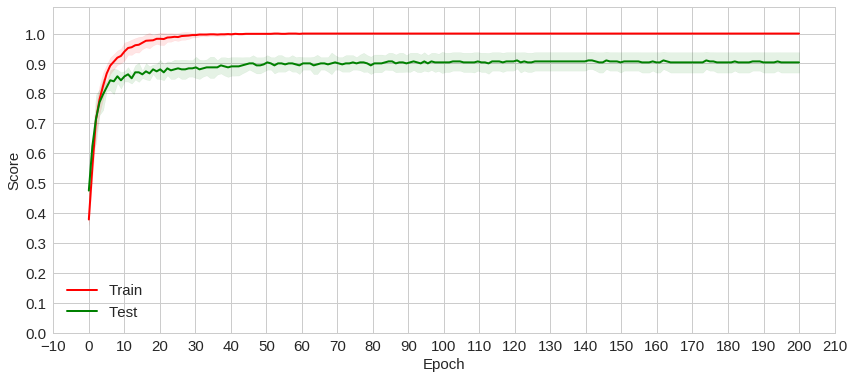

In [39]:
plot_mean_acc(tophist)

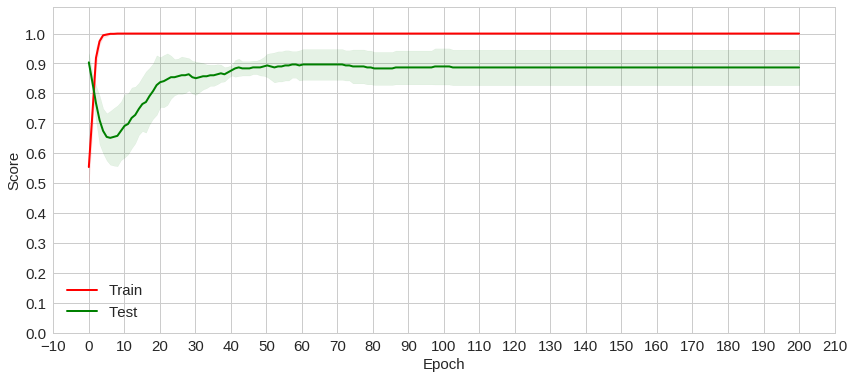

In [40]:
plot_mean_acc(hist)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-0.9,10.9))
    plt.show()

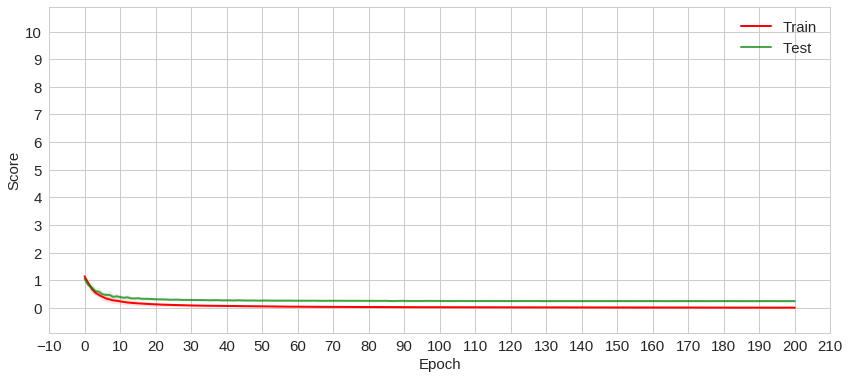

In [42]:
plot_mean_loss(tophist)

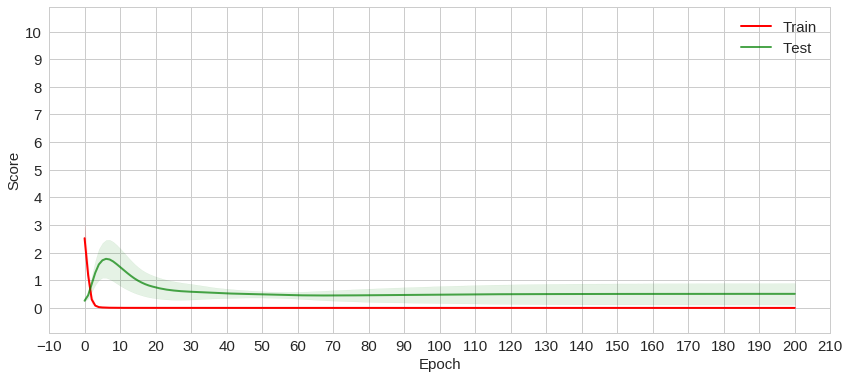

In [43]:
plot_mean_loss(hist)